# Trias Analysis
This notebook provides a workflow for analyzing codon usage patterns and reproducing the figures in the **Trias** paper.

The following section loads all necessary packages and sets up the environment for plotting, analysis, and model configuration.  

In [49]:
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
import seaborn as sns
# Plot style settings
sns.set_theme(style="white", context="paper", palette="pastel")
# Tracking progress
from tqdm import tqdm
# Data and stats libraries
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from scipy.stats import spearmanr, chi2_contingency, linregress, ttest_ind
from sklearn.metrics import confusion_matrix
from gprofiler import GProfiler
# Deep learning & NLP
from transformers import BartForConditionalGeneration
from datasets import load_dataset
import torch
# Trias-specific imports
from trias import *
from notebook_utils import *

# Initialize tokenizer and model
model_path = "lareaulab/Trias"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = BartForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval();

### Data Loading

Defining paths to the datasets and loading all required data files used throughout the analysis.

> **Note**: Update `DATA_DIR` and `FIGURE_DIR` to match your own setup.

In [ ]:
# === Set Data and Figure Directories ===
# Change these paths based on your environment 
DATA_DIR = '/path_to/data/' 
FIGURE_DIR = '/path_to/figures/'  # optional, if saving figures

# === Load Datasets ===
# Codon frequency
codon_table = pd.read_csv(f"{DATA_DIR}codon_table.csv")
srscu_df = codon_table[['codon','srscu']].set_index('codon')
srscu_dict = srscu_df.srscu.to_dict()
abs_codon_count_dict = codon_table.set_index('codon')['abs_codon_count'].to_dict()
rel_codon_count = codon_table.set_index('codon')['rel_codon_count']

# Load test dataset
human_testset_df = pd.read_csv(f"{DATA_DIR}human_test_dataset.csv")
one_isoform_df = human_testset_df.groupby('gene_name').agg({
    'acc_trias': 'mean',
    'srscu_wildtype': 'mean',
    'srscu_trias': 'mean',
    'entropy_trias': 'mean'
}).reset_index()

max_codons = 2043
columns = list(range(max_codons))
# Helper function to split into codons with padding
def split_codons(seq):
    return [seq[i:i+3] if i+3 <= len(seq) else None for i in range(0, max_codons * 3, 3)] if isinstance(seq, str) else [None]*max_codons
# Create DataFrames for per codon analysis
true_codon = pd.DataFrame({row['record_id']: split_codons(row['wildtype_seq']) for _, row in human_testset_df.iterrows()}, index=columns).T
predicted_codon = pd.DataFrame({row['record_id']: split_codons(row['trias_seq']) for _, row in human_testset_df.iterrows()}, index=columns).T
true_codon.index.name = 'record_id'
predicted_codon.index.name = 'record_id'

# Pfam domain annotations from InterPro
interpro_col = [
    'Protein Accession', 'Sequence MD5 digest', 'Sequence length', 'Analysis',
    'Signature accession', 'Signature description', 'Start location', 'Stop location',
    'Score', 'Status', 'Date', 'InterPro annotations - accession',
    'InterPro annotations - description', 'GO annotations', 'Pathways annotations'
]
domain_df = pd.read_csv(f"{DATA_DIR}interpro_output.tsv", sep='\t', header=None, names=interpro_col)
pfam_domain_df = domain_df[domain_df['Analysis'] == 'Pfam']
pfam_domain_df = pfam_domain_df[pfam_domain_df['Score'].astype(float) < 1e-5]
pfam_domain_df["record_id"] = pfam_domain_df["Protein Accession"].str.split("|").str[0]
pfam_domain_df["Start location"] = pfam_domain_df["Start location"].astype(int)
pfam_domain_df["Stop location"] = pfam_domain_df["Stop location"].astype(int)

# GFP variant data
gfp_data = pd.read_csv(f"{DATA_DIR}gfp_moore.csv")

# GTEx expression data
gtex_data = pd.read_csv(f"{DATA_DIR}GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz", sep='\t', skiprows=2)
# Filter out genes with all zero TPMs
tpm_columns = gtex_data.columns[2:]
gtex_data = gtex_data[(gtex_data[tpm_columns] != 0).any(axis=1)]
# Compute median expression per gene
gtex_data['Median'] = gtex_data[tpm_columns].median(axis=1)
# Merge with codon evaluation scores
gene_expression_df = pd.merge(
    one_isoform_df,
    gtex_data[['Description', 'Median']],
    left_on='gene_name',
    right_on='Description',
    how='left'
).drop(columns=['Description'])
# Clean up duplicates and missing values
gene_expression_df = (
    gene_expression_df
    .sort_values('Median', ascending=False)
    .drop_duplicates(subset=['gene_name'], keep='first')
    .dropna()
)
# Log-transform median expression
gene_expression_df['Log2Median'] = np.log2(gene_expression_df['Median'] + 1)

## Figure 1 : Training Performance

In [8]:
examples = 20
selected_records = human_testset_df.sample(n=examples, random_state=42)["record_id"].tolist()
df_selected = human_testset_df[human_testset_df["record_id"].isin(selected_records)]
sequences = df_selected.apply(generate_prompt_from_dataset, axis=1).tolist()

labels = generate_labels(df_selected, examples=examples, srscu_df=srscu_df.srscu, max_length_data=2046, level="token")

encoder_embeddings_tokens = extract_embeddings(model, tokenizer, sequences, layer=-1, exclude_first_n_tokens=1, bart_state="encoder", level="token")

In [9]:
reduced_dim = reduce_dimensionality(encoder_embeddings_tokens, method='tsne', perplexity=20, n_components=2, n_iter=1_000)

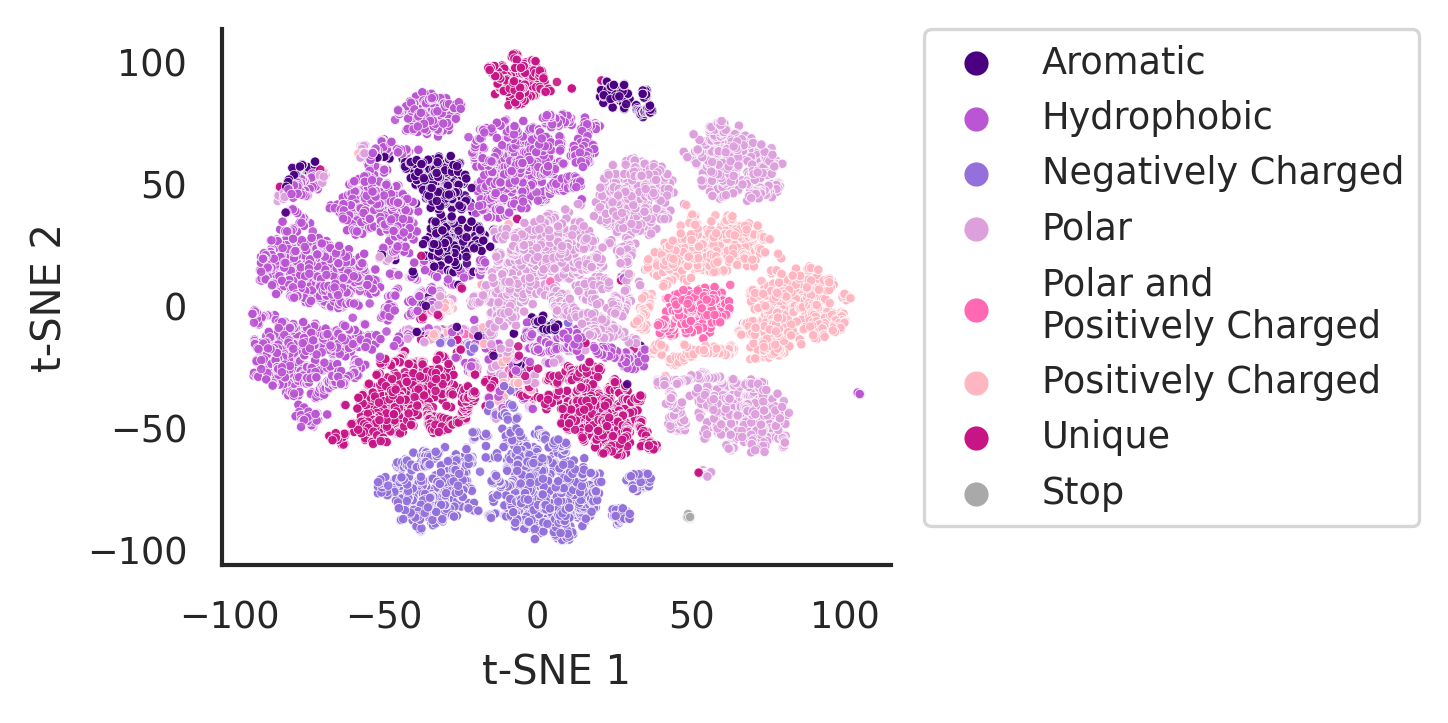

In [10]:
# Species, Amino Acid, Codon, Polarity, Charge, Volume, Chemical, Hydropathy, GC content, Properties, sRSCU
plot_embeddings(reduced_dim, labels, label_name="Properties", figure_name=FIGURE_DIR+"figure_1F.pdf")

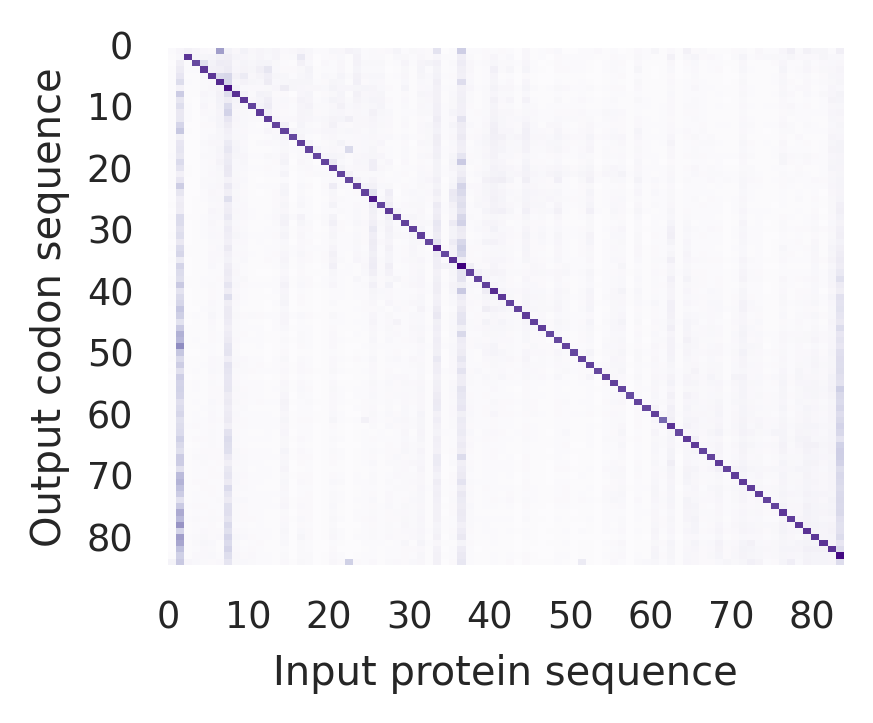

In [11]:
# randomly select small human protein and plot attention map
small_protein_row = human_testset_df[(human_testset_df['protein'].str.len() <= 100)].sample(1, random_state=0).iloc[0]
small_protein_prompt = generate_prompt_from_dataset(small_protein_row)
plot_attention_weights(model, tokenizer, small_protein_prompt, device=device, head=5, attention_type="cross", figure_name=FIGURE_DIR+"figure_1G.pdf")

In [13]:
# Flatten the DataFrames
true_codons = true_codon.values.flatten()  # Convert to 1D array
pred_codons = predicted_codon.values.flatten()  # Convert to 1D array
# Remove None or NaN values
mask = ~pd.isnull(true_codons) & ~pd.isnull(pred_codons)
true_codons = true_codons[mask]
pred_codons = pred_codons[mask]
# Find the most frequent codon for each amino acid
most_frequent_codons = {}
for aa, codon_group in aa_to_codon.items():
    freq_values = rel_codon_count[codon_group]
    most_frequent_codon = freq_values.astype(float).idxmax()
    most_frequent_codons[aa] = most_frequent_codon
# Flatten the aa_to_codon to create an ordered codon list
sorted_codon_labels = [codon for codons in aa_to_codon.values() for codon in codons]
# Filter out codons not present in true_codons or pred_codons (ensure all are present in the sorted list)
codon_labels_present = np.unique(np.concatenate((true_codons, pred_codons)))
sorted_codon_labels = [codon for codon in sorted_codon_labels if codon in codon_labels_present]
# Create the confusion matrix
conf_matrix = confusion_matrix(true_codons, pred_codons, labels=sorted_codon_labels)
# Normalize the confusion matrix per amino acid
conf_matrix_normalized = np.zeros_like(conf_matrix, dtype=float)

for aa, codon_group in aa_to_codon.items():
    # Get the indices for the synonymous codons of this amino acid
    codon_indices = [sorted_codon_labels.index(codon) for codon in codon_group if codon in sorted_codon_labels]
    if codon_indices:
        # Extract the submatrix for this amino acid group
        submatrix = conf_matrix[np.ix_(codon_indices, codon_indices)]
        # Normalize each row of the submatrix to sum to 100 (percentage within this amino acid)
        row_sums = submatrix.sum(axis=1, keepdims=True)
        normalized_submatrix = np.divide(submatrix, row_sums, where=row_sums != 0) * 100  # Avoid division by zero
        # Insert the normalized submatrix back into the overall matrix
        for i, idx1 in enumerate(codon_indices):
            for j, idx2 in enumerate(codon_indices):
                conf_matrix_normalized[idx1, idx2] = normalized_submatrix[i, j]


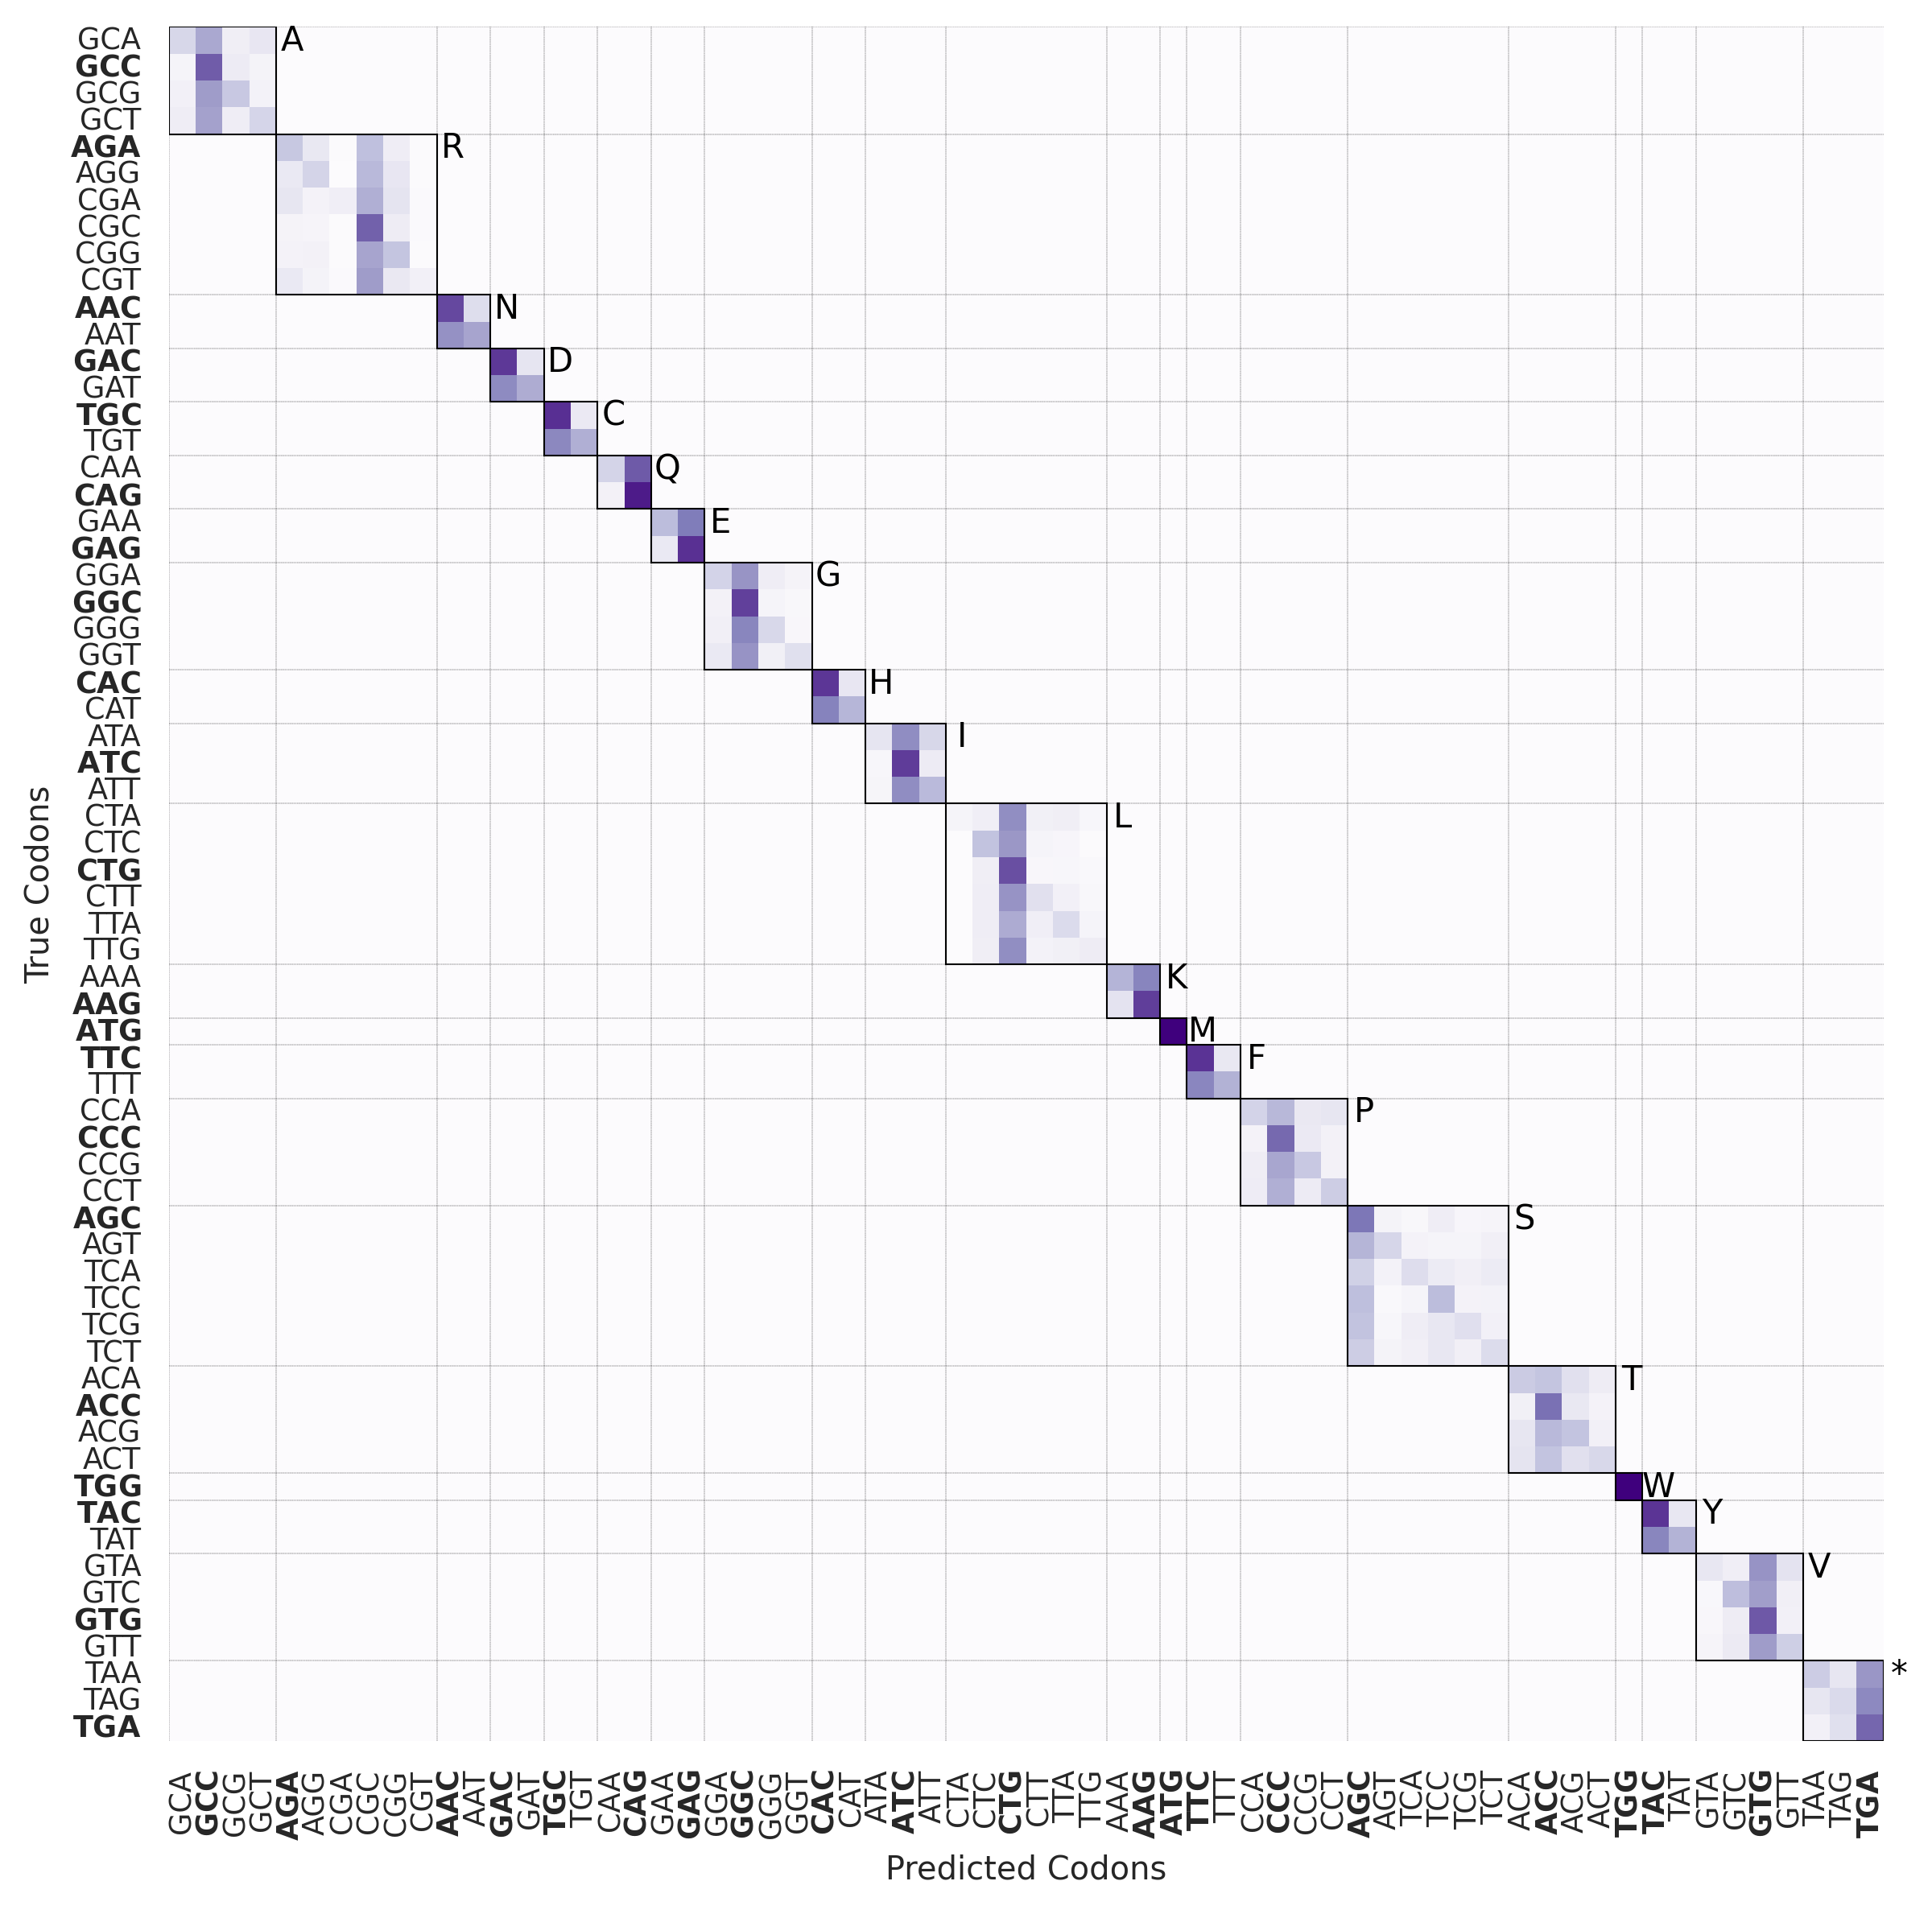

In [14]:
# Plot the confusion matrix as a heatmap 
plt.figure(figsize=(8, 8), dpi=300)
# Custom label formatter to bold the most frequent codon
def bold_most_frequent_label(label):
    for aa, codon in most_frequent_codons.items():
        if label == codon:
            return f"$\\bf{{{label}}}$" 
    return label

# Format the codon labels with the custom formatter
formatted_xlabels = [bold_most_frequent_label(label) for label in sorted_codon_labels]
formatted_ylabels = [bold_most_frequent_label(label) for label in sorted_codon_labels]

ax = sns.heatmap(conf_matrix_normalized, xticklabels=formatted_xlabels, yticklabels=formatted_ylabels, cmap="Purples", annot=False, cbar=False)
plt.xlabel("Predicted Codons")
plt.ylabel("True Codons")
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.tight_layout()
# Draw black boxes around synonymous codon groups, dashed lines, and annotate amino acids
for aa, codon_group in aa_to_codon.items():
    # Find the start and end index of each synonymous group in sorted_codon_labels
    codon_indices = [sorted_codon_labels.index(codon) for codon in codon_group if codon in sorted_codon_labels]
    if codon_indices:
        start = min(codon_indices)
        end = max(codon_indices)
        # Add a rectangle around this codon group
        ax.add_patch(patches.Rectangle((start, start), end-start+1, end-start+1, fill=False, edgecolor='black', lw=0.5))
        # Add dashed lines to x-axis (codon labels) and y-axis (codon labels)
        plt.axhline(y=start, color='black', linestyle='--', linewidth=.1)
        plt.axvline(x=start, color='black', linestyle='--', linewidth=.1)
        # Annotate the upper-right corner of the rectangle with the amino acid
        ax.text(end + 1.6, start + 0.5, aa, color='black', fontsize=10, ha='center', va='center')

# Show the heatmap
plt.savefig(FIGURE_DIR+"figure_S1.pdf", format="pdf")
plt.show()


In [15]:
mutational_distances = []
mismatch_positions = []
mutation_types = []

for t_codon, p_codon in zip(true_codons, pred_codons):
    distance, mismatch_position = calculate_mutational_distance(t_codon, p_codon)
    if distance is not None:
        mutational_distances.append(distance)
        mismatch_positions.extend(mismatch_position)
        mutation_types.extend(classify_mutation(t_codon, p_codon))

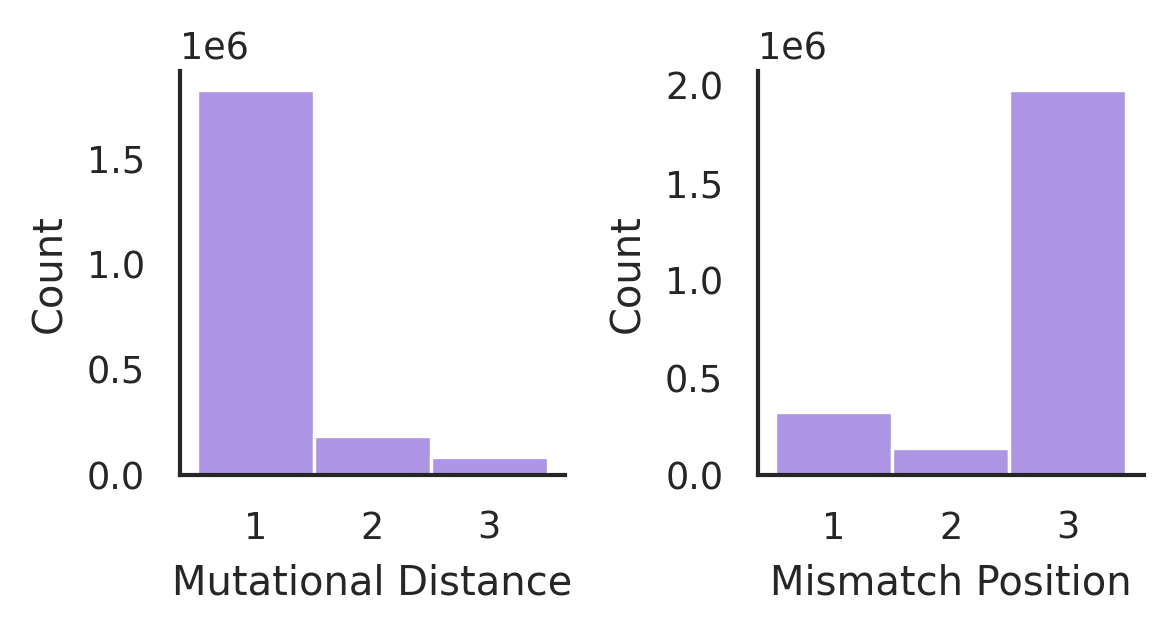

In [16]:
# Helper function to add counts on top of the bars with 'N=' before each count
def annotate_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'N={int(height)}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                        textcoords='offset points')

fig, axes = plt.subplots(1, 2, figsize=(4, 2.2), dpi=300)
ax = sns.histplot(mutational_distances, bins=[0.5, 1.5, 2.5, 3.5], kde=False, ax=axes[0], color='mediumpurple')
axes[0].set_xticks([1, 2, 3])
axes[0].set_xlabel('Mutational Distance')
axes[0].set_ylabel('Count')

ax = sns.histplot(mismatch_positions, bins=[0.5, 1.5, 2.5, 3.5], kde=False, ax=axes[1], color='mediumpurple')
axes[1].set_xticks([1, 2, 3])
axes[1].set_xlabel('Mismatch Position')
axes[1].set_ylabel('Count')

sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_S2_A_B.pdf", format="pdf")
plt.show()


## Figure 2 : Sequence-Level Analysis

In [17]:
annotation_dict = {'NM_018260.3': '*', 'XM_047436097.1': '‡', 'XM_054335535.1': '†', 'NM_001369560.1': '.'}
srscu_threshold_pred = 0.86
low_srscu_genes = human_testset_df[human_testset_df['srscu_trias'] <= srscu_threshold_pred]['record_id'].tolist()


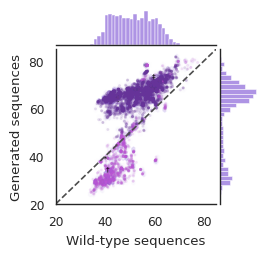

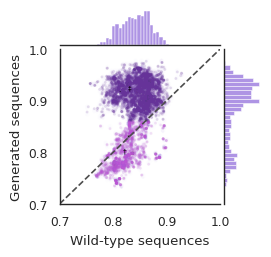

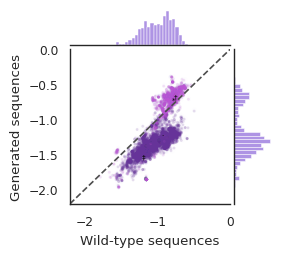

In [18]:
scatter_with_marginals(human_testset_df, 'gc_wildtype', 'gc_trias', 'figure_2A_2', 'Wild-type sequences', 'Generated sequences', figure_dir=FIGURE_DIR, highlighted_genes=low_srscu_genes, annotation_dict=annotation_dict, xlim=(20, 85), ylim=(20, 85))
scatter_with_marginals(human_testset_df, 'srscu_wildtype', 'srscu_trias', 'figure_2A_1', 'Wild-type sequences', 'Generated sequences', figure_dir=FIGURE_DIR, highlighted_genes=low_srscu_genes, annotation_dict=annotation_dict, xlim=(0.7, 1), ylim=(0.7, 1))
scatter_with_marginals(human_testset_df, 'mfe_wildtype', 'mfe_trias', 'figure_2A_3', 'Wild-type sequences', 'Generated sequences', figure_dir=FIGURE_DIR, highlighted_genes=low_srscu_genes, annotation_dict=annotation_dict, xlim=(-2.2, 0), ylim=(-2.2, 0))

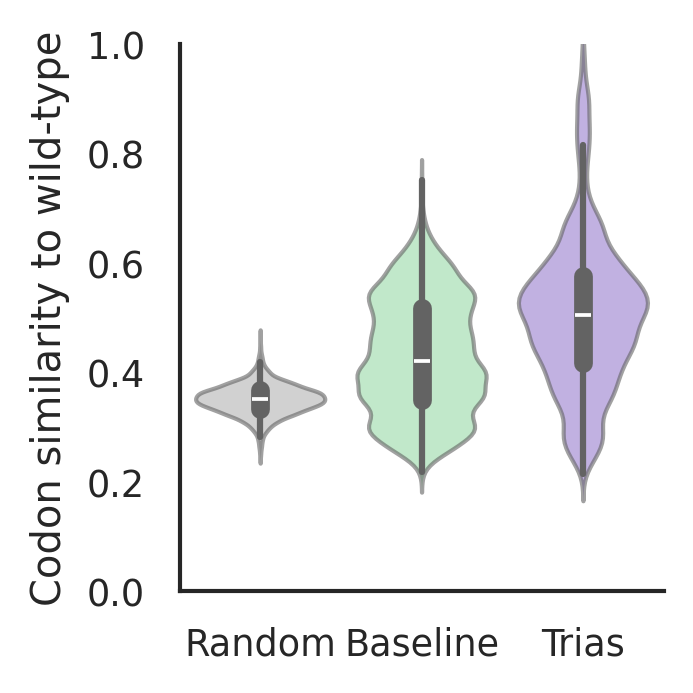

In [19]:
values_to_compare = ['acc_random', 'acc_bayes', 'acc_trias']
df_melted = human_testset_df.melt(id_vars=['gene_name'], value_vars=values_to_compare, 
                    var_name='Model', value_name='Accuracy')
df_melted['Model'] = df_melted['Model'].map({values_to_compare[0]: 'Random', values_to_compare[1]: 'Baseline', values_to_compare[2]: 'Trias'})

plt.figure(figsize=(2.4, 2.4), dpi=300)
ax = sns.violinplot(x='Model', y='Accuracy', hue='Model', data=df_melted, palette=['0.7', 'g', 'mediumpurple'], alpha=0.6)

ax.set_ylim(0,1)
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('Codon similarity to wild-type')
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_2B.pdf", format="pdf")
plt.show()

In [20]:
protein_ids = ['NM_001369560.1', 'XM_047436097.1', 'XM_054335535.1', 'NM_018260.3']
selected_rows = human_testset_df[human_testset_df['record_id'].isin(protein_ids)]
selected_rows.loc[:, 'record_id'] = pd.Categorical(selected_rows['record_id'], categories=protein_ids, ordered=True)
selected_rows = selected_rows.sort_values('record_id').reset_index(drop=True)
window_size = 18
true_min_max = []
predicted_min_max = []
for i in range(len(protein_ids)): 
    true_min_max.append(calculate_min_max(seq_to_codons(selected_rows.wildtype_seq[i]), abs_codon_count_dict, codon_to_aa, window_size))
    predicted_min_max.append(calculate_min_max(seq_to_codons(selected_rows.trias_seq[i]), abs_codon_count_dict, codon_to_aa, window_size))


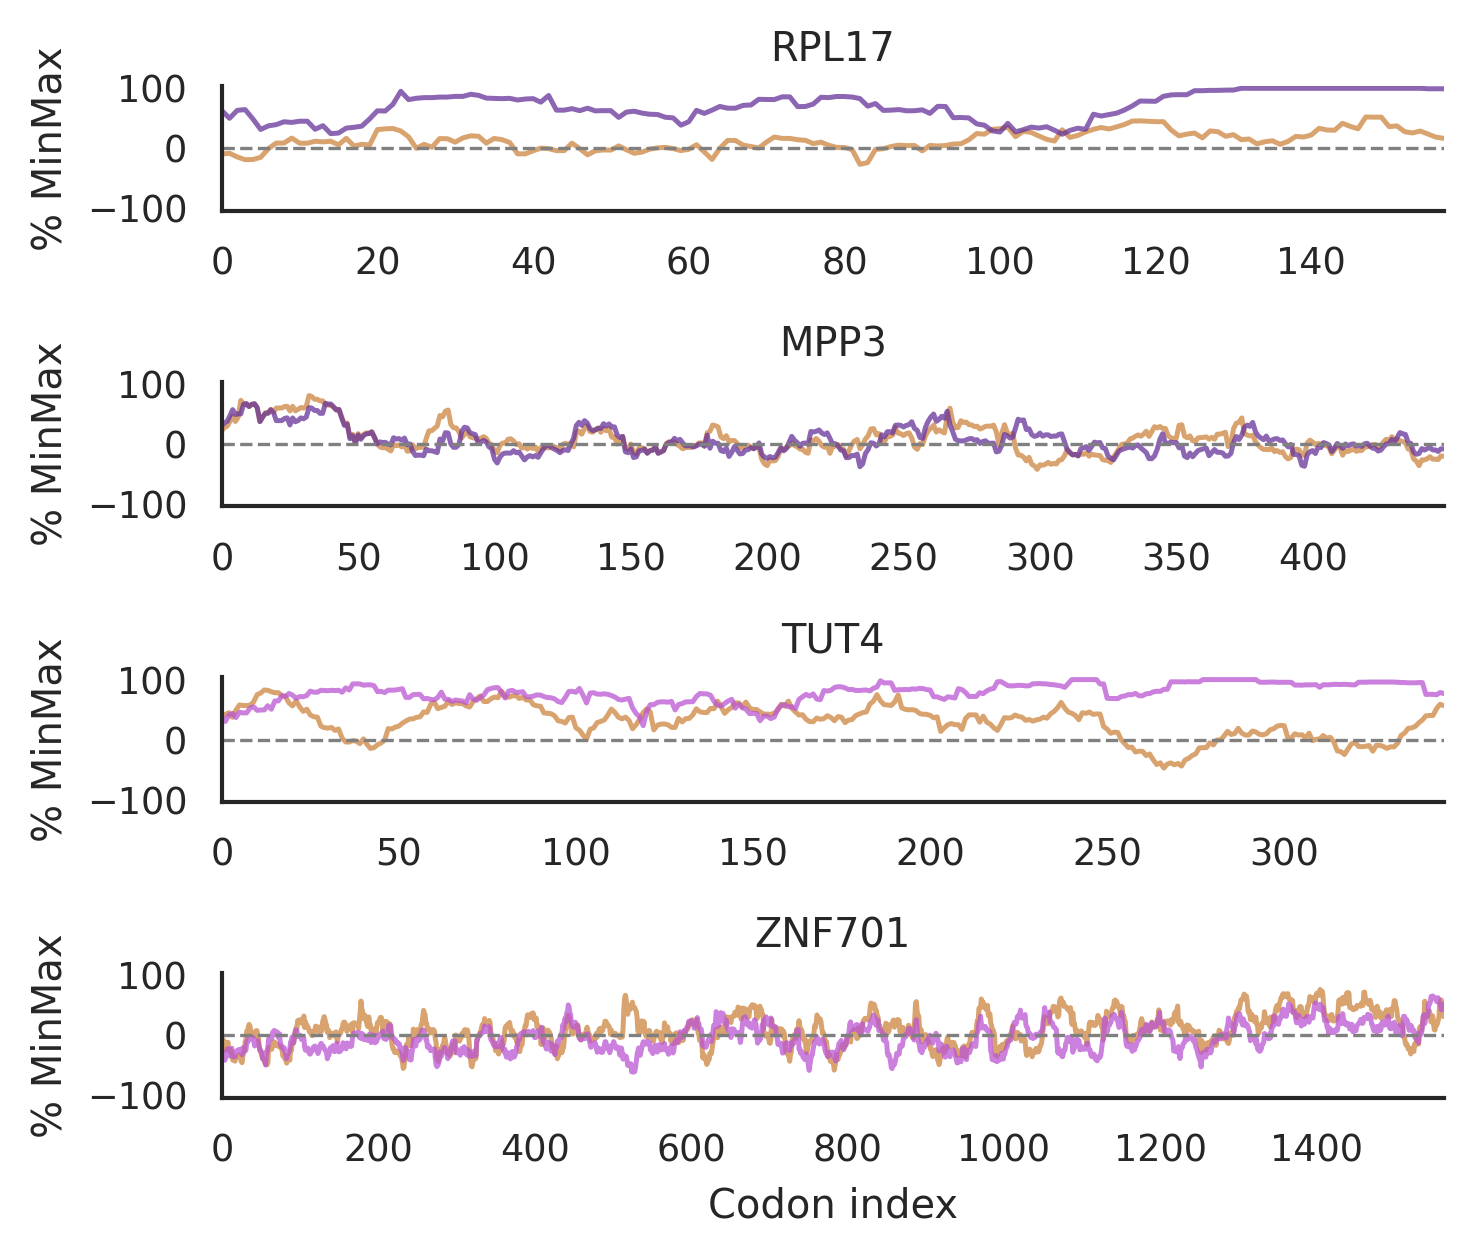

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(5., 4.5), dpi=300)
axes = axes.flatten()
# Gene names and their categories
gene_info = {
    'NM_018260.3': {'name': 'ZNF701', 'category': 'Low sRSCU'},
    'XM_054335535.1': {'name': 'TUT4', 'category': 'Low sRSCU'},
    'XM_047436097.1': {'name': 'MPP3', 'category': 'High sRSCU'},
    'NM_001369560.1': {'name': 'RPL17', 'category': 'High sRSCU'},
}
# Create each subplot
for idx, (gene_id, gene_data) in enumerate(zip(protein_ids, zip(true_min_max, predicted_min_max))):
    ax = axes[idx]
    # Extract the Min/Max values
    true_values = gene_data[0]
    predicted_values = gene_data[1]
    codon_indices = list(range(len(true_values)))
    category = gene_info[gene_id]['category']
    color = 'mediumorchid' if category == 'Low sRSCU' else 'rebeccapurple'
    # Plot true and predicted Min/Max values
    ax.plot(codon_indices, true_values, label='Wild-type', color='peru', alpha=0.75)
    ax.plot(codon_indices, predicted_values, label='Trias', color=color, alpha=0.75)
    # Add title and labels
    gene_name = gene_info[gene_id]['name']
    ax.set_title(f"{gene_name}")
    if idx == 3: ax.set_xlabel("Codon index")  # Only for bottom row
    ax.set_ylabel("% MinMax")
    ax.set_ylim(-104, 104)
    ax.set_xlim(0,codon_indices[-1])
    ax.axhline(0, color='0.5', linestyle='--', linewidth=0.8)

handles, labels = axes[0].get_legend_handles_labels()
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIGURE_DIR+"figure_2C.pdf", format="pdf")
plt.show()

In [22]:
def add_correlations(ax, x, y, pos_x=0.05, pos_y=0.95):
    # Calculate correlations
    spearman_r, spearman_p = spearmanr(x, y, nan_policy='omit')    
    # Add text with correlations
    ax.text(pos_x, pos_y, f'Spearman ρ = {spearman_r:.2f}', 
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='top',
            linespacing=1.2)
    print(spearman_p)

0.001589778159000994


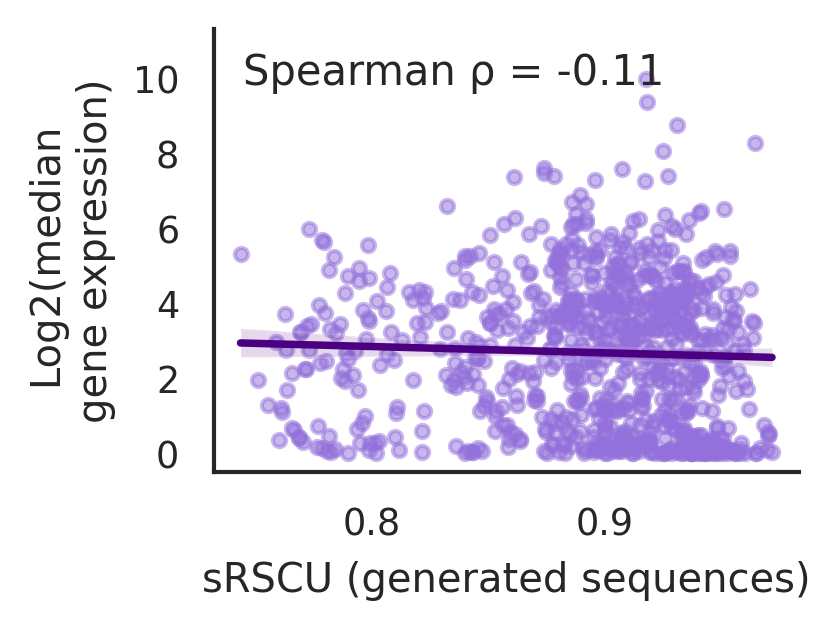

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(2.85, 2.19), dpi=300)
sns.regplot(ax=axs, x='srscu_trias', y='Log2Median', data=gene_expression_df, scatter_kws={"s": 10, "alpha":0.5}, line_kws={"color": "indigo"}, color='mediumpurple')
axs.set_xlabel('sRSCU (generated sequences)')
axs.set_ylabel('Log2(median \ngene expression)')
add_correlations(axs, gene_expression_df['srscu_trias'], gene_expression_df['Log2Median'])
axs.set_ylim(-.5,11.3)
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_2E.pdf", format="pdf")
plt.show()


In [24]:
high_srscu_genes = one_isoform_df[one_isoform_df['srscu_trias'] > srscu_threshold_pred]['gene_name'].tolist()
low_srscu_genes = one_isoform_df[one_isoform_df['srscu_trias'] <= srscu_threshold_pred]['gene_name'].tolist()
all_human_test_genes = list(set(human_testset_df['gene_name'].tolist()))
# Perform GO enrichment analysis
gp = GProfiler(return_dataframe=True)
go_results = gp.profile(
    organism='hsapiens', 
    no_evidences=False,
    query=low_srscu_genes, #high_srscu_genes
    background=all_human_test_genes,
    sources=['GO:MF'], # 'GO:BP', 'GO:CC', 'GO:MF',
    significance_threshold_method='bonferroni', 
    user_threshold=0.05,
)
go_results = go_results.sort_values(by='p_value')
go_results['log_p_value'] = -np.log10(go_results['p_value'])
go_results['term_with_source'] = go_results.apply(lambda row: f"{row['name']} ({row['source']})", axis=1)
go_results["GeneRatio"] = go_results["intersection_size"] / go_results["query_size"]
def wrap_go_name(name, width=30):
    import textwrap
    return "\n".join(textwrap.wrap(name, width))
# Apply wrapping to the 'name' column (you can adjust width to your liking)
go_results['name'] = go_results['name'].apply(lambda x: wrap_go_name(x, width=40))
go_results = go_results.sort_values("GeneRatio", ascending=False)

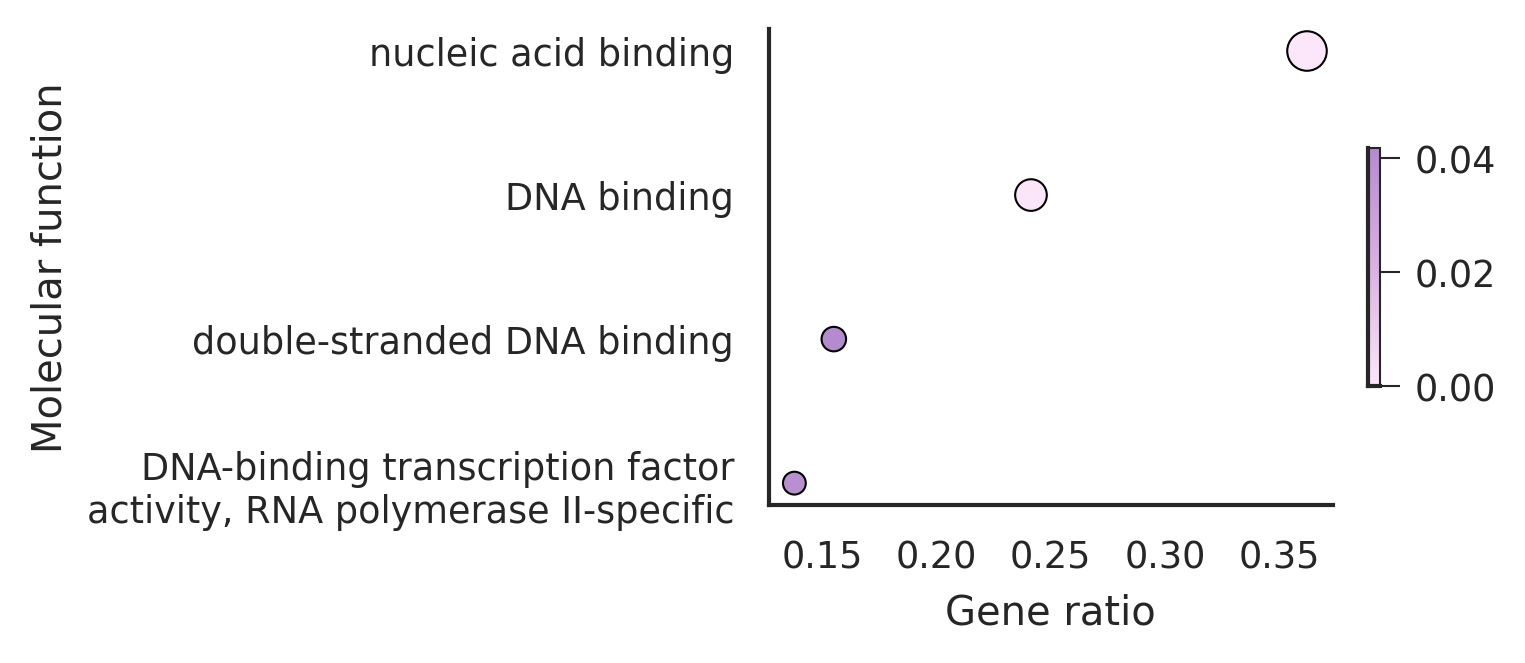

In [25]:
mediumorchid_cmap = mcolors.LinearSegmentedColormap.from_list(
    "mediumorchid", ["#fce6f9", "#dab1e2", "#b58bcf"]
)
fig, ax = plt.subplots(figsize=(5.1, 2.3), dpi=300)
dot = sns.scatterplot(
    data=go_results,
    x="GeneRatio",
    y="name",
    size="intersection_size",
    hue="p_value",
    palette=mediumorchid_cmap,
    sizes=(30, 90),
    edgecolor="black",
    linewidth=0.5,
    legend="brief",
    marker="o",
    ax=ax 
)

dot.legend_.remove()
# Create ScalarMappable with same colormap and normalization
norm = mcolors.Normalize(0., go_results["p_value"].max())
sm = ScalarMappable(cmap=mediumorchid_cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5)
ax.set_xlabel("Gene ratio")
ax.set_ylabel("Molecular function")
sns.despine()
fig.tight_layout()
fig.savefig(FIGURE_DIR + "figure_2F.pdf", format="pdf")
plt.show()

In [26]:
gc_srscu_df = codon_table[['codon', 'srscu']].copy()
gc_srscu_df['amino acid'] = gc_srscu_df["codon"].apply(lambda x: codon_to_aa[x])
gc_srscu_df["gc content"] = gc_srscu_df["codon"].apply(calculate_gc_content)
unique_aa = [aa for aa in gc_srscu_df["amino acid"].unique() if aa not in ["Met", "Trp", "Stop"]]

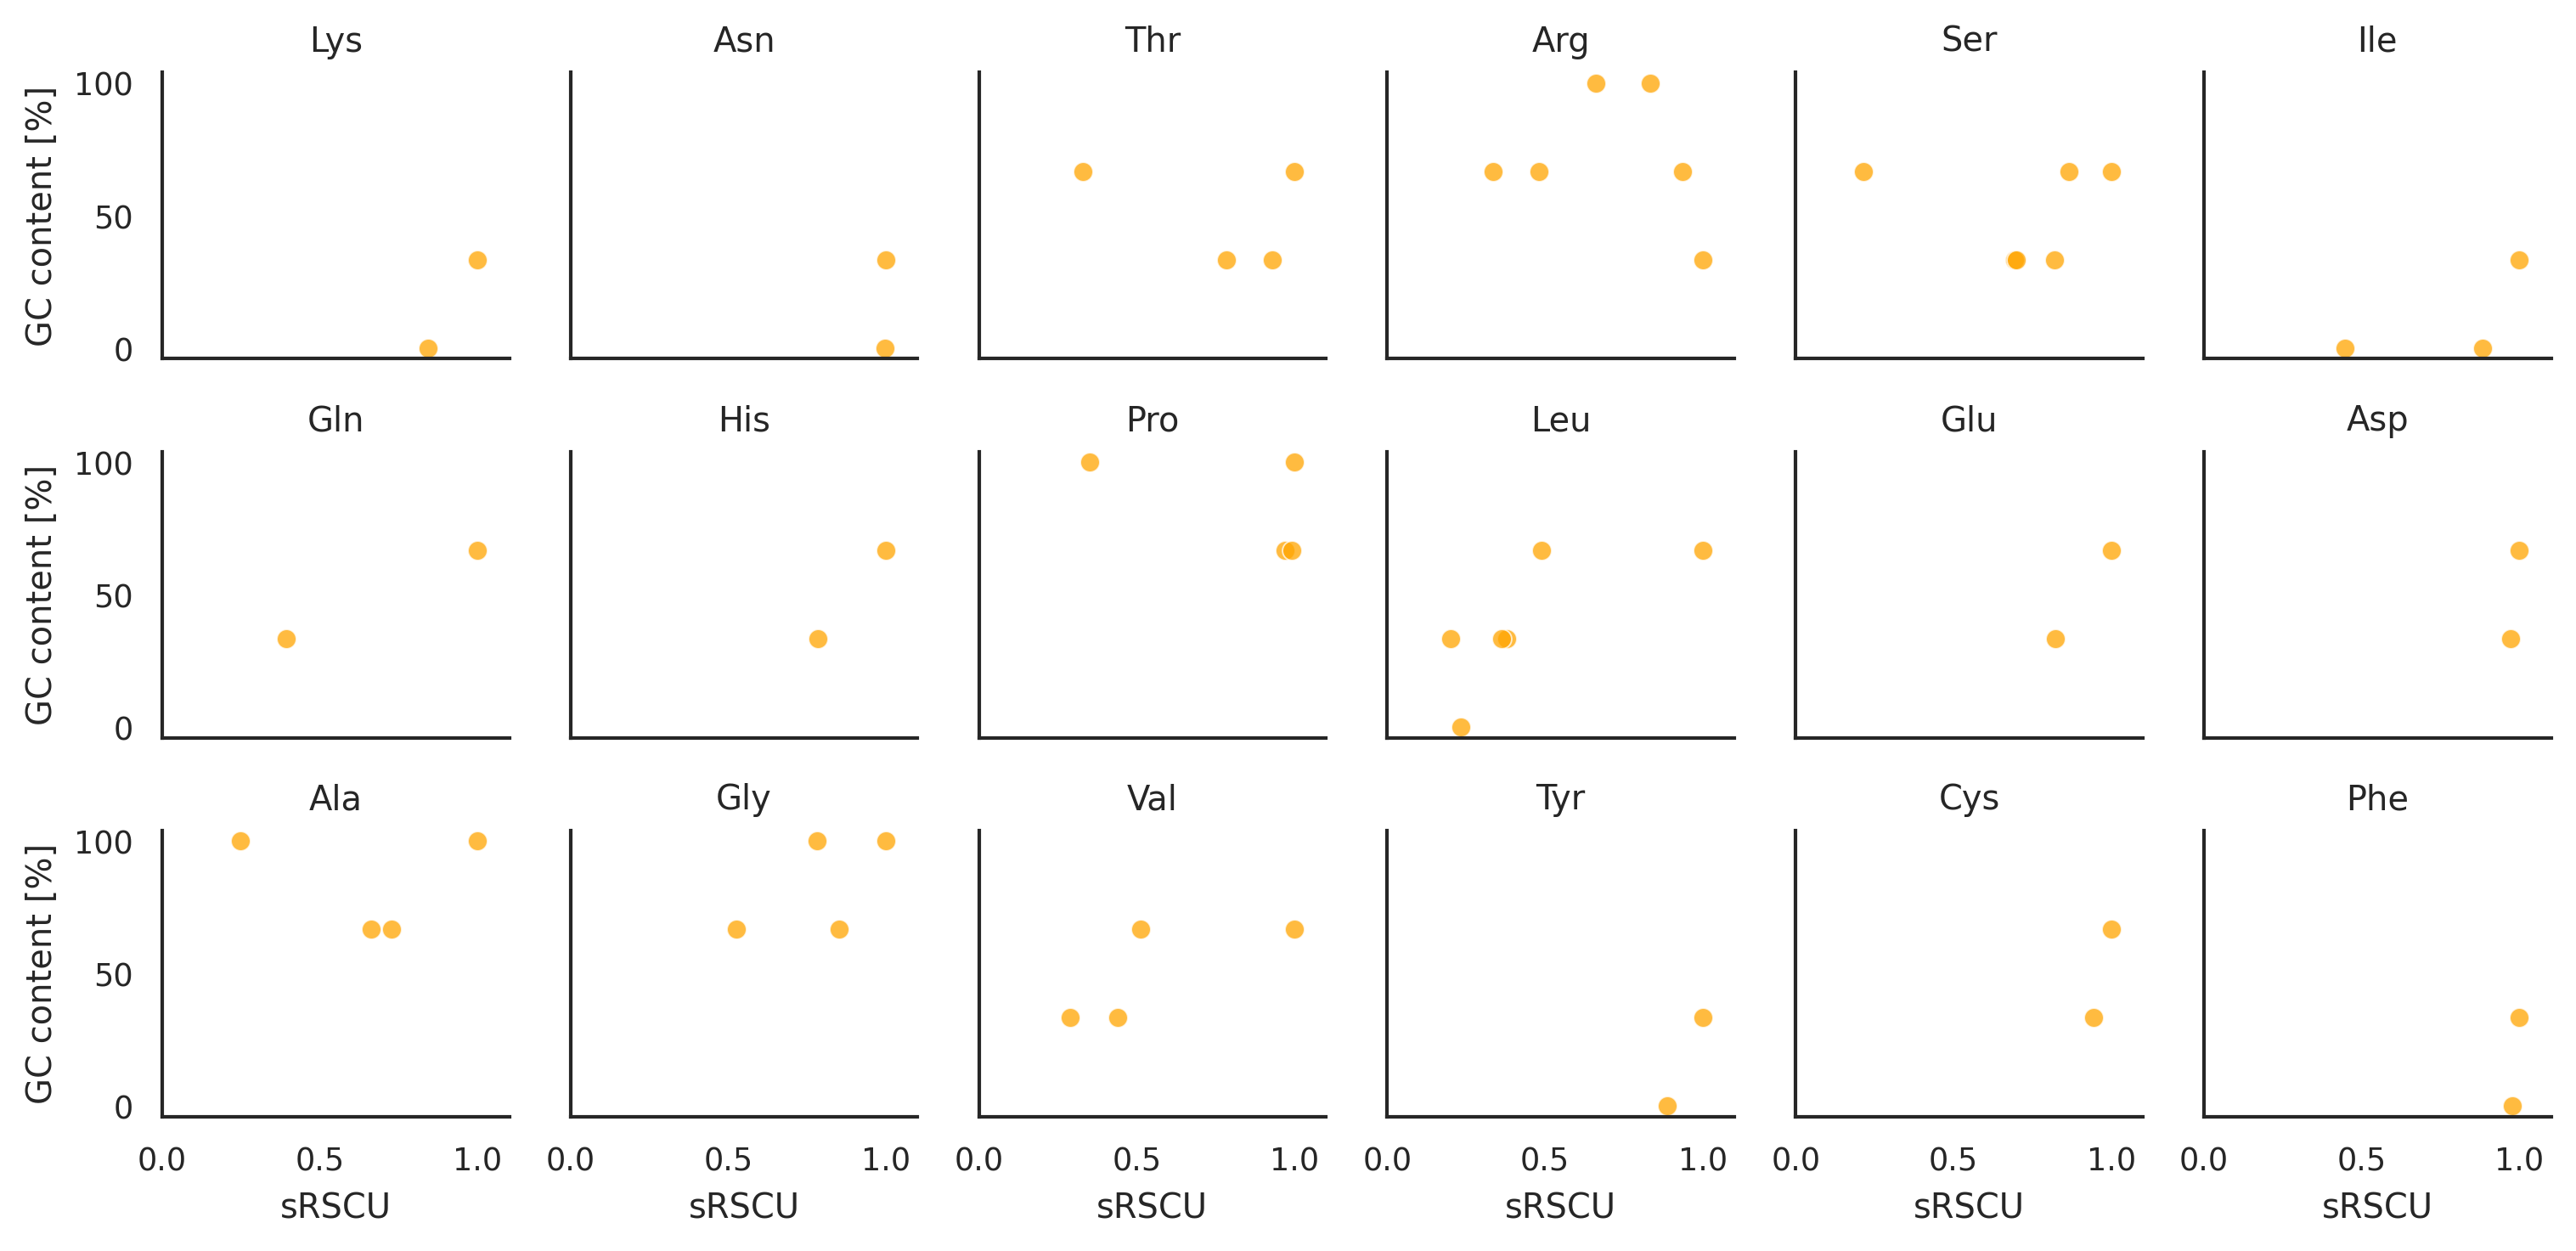

In [27]:
fig, axes = plt.subplots(3, 6, figsize=(10.2,5), sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
# Plot each amino acid's codons
for i, aa in enumerate(unique_aa):
    ax = axes[i]
    aa_data = gc_srscu_df[gc_srscu_df["amino acid"] == aa]
    sns.scatterplot(
        data=aa_data,
        x="srscu",
        y="gc content",
        color='orange',
        alpha=0.75,
        ax=ax,
        s=30
    )
    ax.set_xlim(0., 1.1)
    ax.set_ylim(-4, 104)
    ax.set_title(aa)
    ax.set_ylabel("GC content [%]")
    ax.set_xlabel("sRSCU")
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_S5.pdf", format="pdf")
plt.show()


# Figure 3 : Codon-Level Analysis

In [28]:
aa_to_srscu = {}
for codon, aa in codon_to_aa.items():
    if codon in srscu_dict:
        if aa not in aa_to_srscu:
            aa_to_srscu[aa] = []
        aa_to_srscu[aa].append(srscu_dict[codon])

sorted_aa = sorted(aa_to_srscu.keys(), key=lambda aa: len(aa_to_srscu[aa]))
aa_positions = {aa: i for i, aa in enumerate(sorted_aa)}

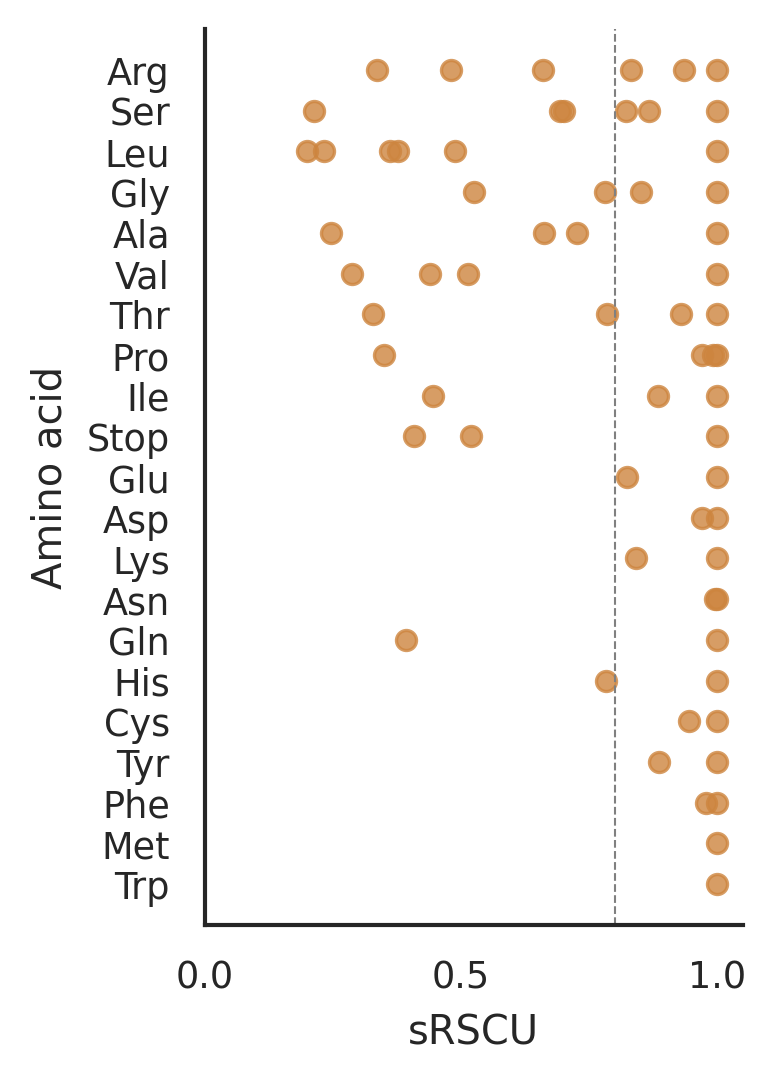

In [29]:
# Plot each amino acid's corresponding SRSCU values
plt.figure(figsize=(2.7, 3.7),dpi=300)
for aa, values in aa_to_srscu.items():
    plt.scatter(values, [aa_positions[aa]] * len(values), color='peru', alpha=.8)

plt.yticks(range(len(sorted_aa)), sorted_aa)
plt.axvline(0.8, color='0.5', linewidth=0.5, linestyle="--")
plt.xlim(0,1.05)
plt.xlabel("sRSCU")
plt.ylabel("Amino acid")
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_3A.pdf", format="pdf")
plt.show()


In [30]:
count = (~predicted_codon.isna() & ~true_codon.isna()).astype(int)
accuracy = (predicted_codon==true_codon).astype(int)
amino_acid = true_codon.replace(codon_to_aa)
seq_lens = count.sum(axis=1)
true_codon_srscu = true_codon.applymap(lambda codon: srscu_dict.get(codon, None))  
pred_codon_srscu = predicted_codon.applymap(lambda codon: srscu_dict.get(codon, None))  

In [31]:
# Create mask for if codon is in domain or not
domain_mask_df = true_codon.copy().astype(object)
domain_mask_df[:] = None
domain_mask_df[count == 1] = 0 

for record_id, group in pfam_domain_df.groupby("record_id"):
    if record_id in domain_mask_df.index:
        for _, row in group.iterrows():
            start = row["Start location"] - 1  # Convert to 0-based
            stop = row["Stop location"] - 1
            domain_mask_df.iloc[domain_mask_df.index.get_loc(record_id), start:stop] = 1 
            
# Generate a position array that repeats for each sequence, assuming 2043 positions
codon_index = np.tile(np.arange(2043), len(amino_acid))
protein_len = count.sum(axis=1).loc[:].repeat(2043)
distance_to_stop_codon = protein_len-codon_index
distance_to_stop_codon = distance_to_stop_codon.where(distance_to_stop_codon >= 0, None)

srscu_threshold_nat = 0.8
rare_codon_analysis_df = pd.DataFrame([[categorize_codon(wt, pred,srscu_threshold_nat) 
      for wt, pred in zip(wt_row, pred_row)]
      for wt_row, pred_row in zip(true_codon_srscu.values, pred_codon_srscu.values)],
      index=human_testset_df.record_id,
      columns=true_codon_srscu.columns
)
rare_codon_analysis_df.columns = range(rare_codon_analysis_df.shape[1])

# Stack the data and include Position column
codon_level_analysis_df = pd.DataFrame({
    'Codon Index': codon_index,
    'Distance to Stop': distance_to_stop_codon.to_numpy(),
    'Amino Acid': amino_acid.stack(dropna=False),
    'Predicted Codon': predicted_codon.stack(dropna=False),
    'True Codon': true_codon.stack(dropna=False),
    'Predicted sRSCU': pred_codon_srscu.stack(dropna=False),
    'True sRSCU': true_codon_srscu.stack(dropna=False),
    'Accuracy': accuracy.stack(dropna=False),
    'Count': count.stack(dropna=False),
    'Domain': domain_mask_df.stack(dropna=False),
}).reset_index(drop=True)

codon_level_analysis_df['Codon Category'] = rare_codon_analysis_df.stack(dropna=False).reset_index(drop=True)
codon_level_analysis_df["RSCU Difference"] = codon_level_analysis_df["Predicted sRSCU"] - codon_level_analysis_df["True sRSCU"]

codon_level_analysis_df["Sequence Length"] = np.repeat(seq_lens.values, 2043)[:len(codon_level_analysis_df)]  
codon_level_analysis_df = codon_level_analysis_df.dropna(subset=['True Codon']).reset_index(drop=True)

codon_category_order = ["Correctly predicted \ncommon codon", "Misclassified as \nrare codon",
                        "Correctly predicted \nrare codon", "Misclassified as \ncommon codon"]
codon_level_analysis_df["Codon Category"] = pd.Categorical(codon_level_analysis_df["Codon Category"], categories=codon_category_order, ordered=True)

codon_level_analysis_df["Relative Codon Position"] = ((codon_level_analysis_df["Codon Index"]+1) / codon_level_analysis_df["Sequence Length"]) * 100

desired_column_order = ["Correctly predicted \ncommon codon", "Misclassified as \nrare codon", "Correctly predicted \nrare codon", "Misclassified as \ncommon codon"]  

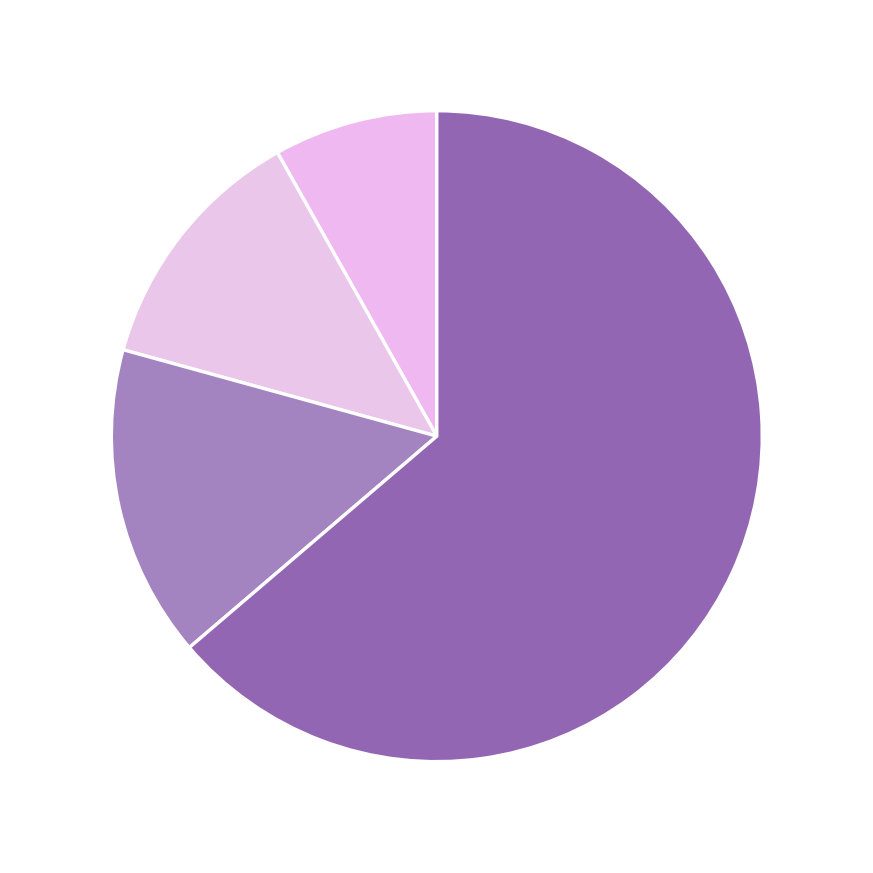

In [32]:
category_counts = codon_level_analysis_df["Codon Category"].value_counts()
base_colors = ["#e68ae6", "plum", "rebeccapurple", "indigo"]
pastel_colors = [mcolors.to_rgba(color, alpha=0.6) for color in base_colors]

plt.figure(figsize=(3., 3.), dpi=300)
plt.pie(
    category_counts.sort_values(),
    labels=None,
    autopct=None, #'%1.f%%',  
    startangle=90,
    colors=pastel_colors,
    wedgeprops={'edgecolor': 'white'},
    textprops={'color': 'white', 'fontsize': 7}
)
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_3B.pdf", format="pdf")
plt.show()

In [33]:
selected_amino_acids = ["Gln", "His", "Ile", "Ala", "Gly", "Pro", "Val", "Thr", "Arg", "Ser", "Leu"] 

In [34]:
codon_pair_df = extract_codon_pairs(codon_level_analysis_df)
codon_pair_df = codon_pair_df.pivot(index="Codon Pair", columns="Codon Category", values="Count").fillna(0)
codon_pair_df["First Codon"] = codon_pair_df.index.str.split("-").str[0]
codon_pair_df["Second Codon"] = codon_pair_df.index.str.split("-").str[1]
codon_pair_df["First AA"] = codon_pair_df["First Codon"].map(codon_to_aa)
codon_pair_df["Second AA"] = codon_pair_df["Second Codon"].map(codon_to_aa)
codon_pair_df["First Codon Label"] = codon_pair_df["First Codon"].map(lambda codon: "Rare" if srscu_dict.get(codon, 0) < srscu_threshold_nat else "Common")
codon_pair_df["Second Codon Label"] = codon_pair_df["Second Codon"].map(lambda codon: "Rare" if srscu_dict.get(codon, 0) < srscu_threshold_nat else "Common")
common_codon_df = codon_pair_df[['Correctly predicted \ncommon codon', 'Misclassified as \nrare codon', 
                                 'First Codon', 'Second Codon', 'First AA', 'Second AA', 'First Codon Label', 'Second Codon Label']].copy()
rare_codon_df = codon_pair_df[['Correctly predicted \nrare codon', 'Misclassified as \ncommon codon', 
                               'First Codon', 'Second Codon', 'First AA', 'Second AA', 'First Codon Label', 'Second Codon Label']].copy()
common_codon_df = common_codon_df.loc[(common_codon_df.iloc[:, :2] != 0).any(axis=1)]
rare_codon_df = rare_codon_df.loc[(rare_codon_df.iloc[:, :2] != 0).any(axis=1)]
# filter for amino acids that have rare and comon codons
common_codon_df = common_codon_df[common_codon_df["Second AA"].isin(selected_amino_acids)]
rare_codon_df = rare_codon_df[rare_codon_df["Second AA"].isin(selected_amino_acids)]

In [35]:
agg_dict = {
    'Correctly predicted \ncommon codon': 'sum', 
    'Misclassified as \nrare codon': 'sum', 
    'Correctly predicted \nrare codon': 'sum', 
    'Misclassified as \ncommon codon': 'sum', 
    'Second Codon': 'sum', 
    'First AA': 'first',
    'Second AA': 'sum', 
    'First Codon Label': 'first',  
    'Second Codon Label': 'sum',    
}

In [36]:
label_groupby = 'First Codon' # First Codon, First AA, First Codon Label
observed_counts_common = codon_pair_df.groupby(label_groupby).agg(agg_dict).iloc[:,:2]
observed_counts_rare = codon_pair_df.groupby(label_groupby).agg(agg_dict).iloc[:,2:4]

_, p_common, _, expected_counts_common = chi2_contingency(observed_counts_common)
_, p_rare, _, expected_counts_rare = chi2_contingency(observed_counts_rare)

total_common = observed_counts_common.sum().sum()
residuals_common = (observed_counts_common - expected_counts_common) / np.sqrt(expected_counts_common)
residuals_rare = (observed_counts_rare - expected_counts_rare) / np.sqrt(expected_counts_rare)


In [37]:
residuals_rare_long = residuals_rare.reset_index().melt(
    id_vars=label_groupby,
    var_name="Codon Category",
    value_name="Residual"
)
residuals_common_long = residuals_common.reset_index().melt(
    id_vars=label_groupby,
    var_name="Codon Category",
    value_name="Residual"
)

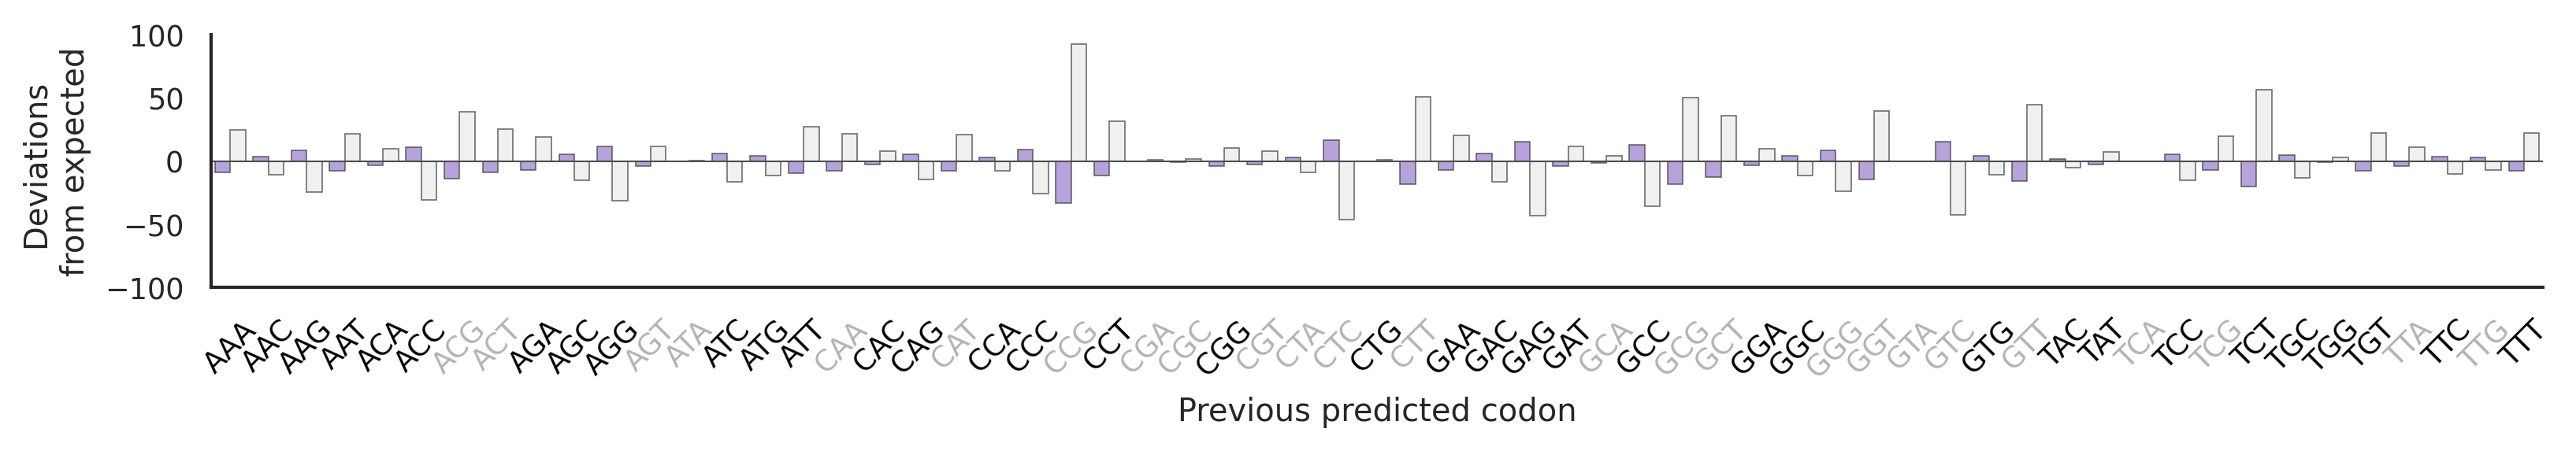

In [38]:
plt.figure(figsize=(11., 2), dpi=300) # Codon label: 3x1.7, AA: 7, Codon: 11x2
ax = sns.barplot(
    data=residuals_common_long,
    x=label_groupby,
    y="Residual",
    hue="Codon Category",
    palette=["mediumpurple", "0.92"], 
    edgecolor="0.2",
    linewidth=0.4,
    alpha=0.7,
    legend=False,
)

# Color x-tick labels gray if codon is rare
for tick_label in ax.get_xticklabels():
    codon = tick_label.get_text()
    if srscu_dict.get(codon, 0) < srscu_threshold_nat:
        tick_label.set_color("0.7")
    else:
        tick_label.set_color("black")

ax.tick_params(axis='x', rotation=45) # 0, 45
ax.set_ylim(-100,100) # 100, 30
ax.axhline(0, color="0.3", linestyle="-", linewidth=0.5)
ax.set_ylabel("Deviations \nfrom expected")
ax.set_xlabel("Previous predicted codon") # predicted codon, amino acid
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_S8_A1.pdf", format="pdf")
plt.show()

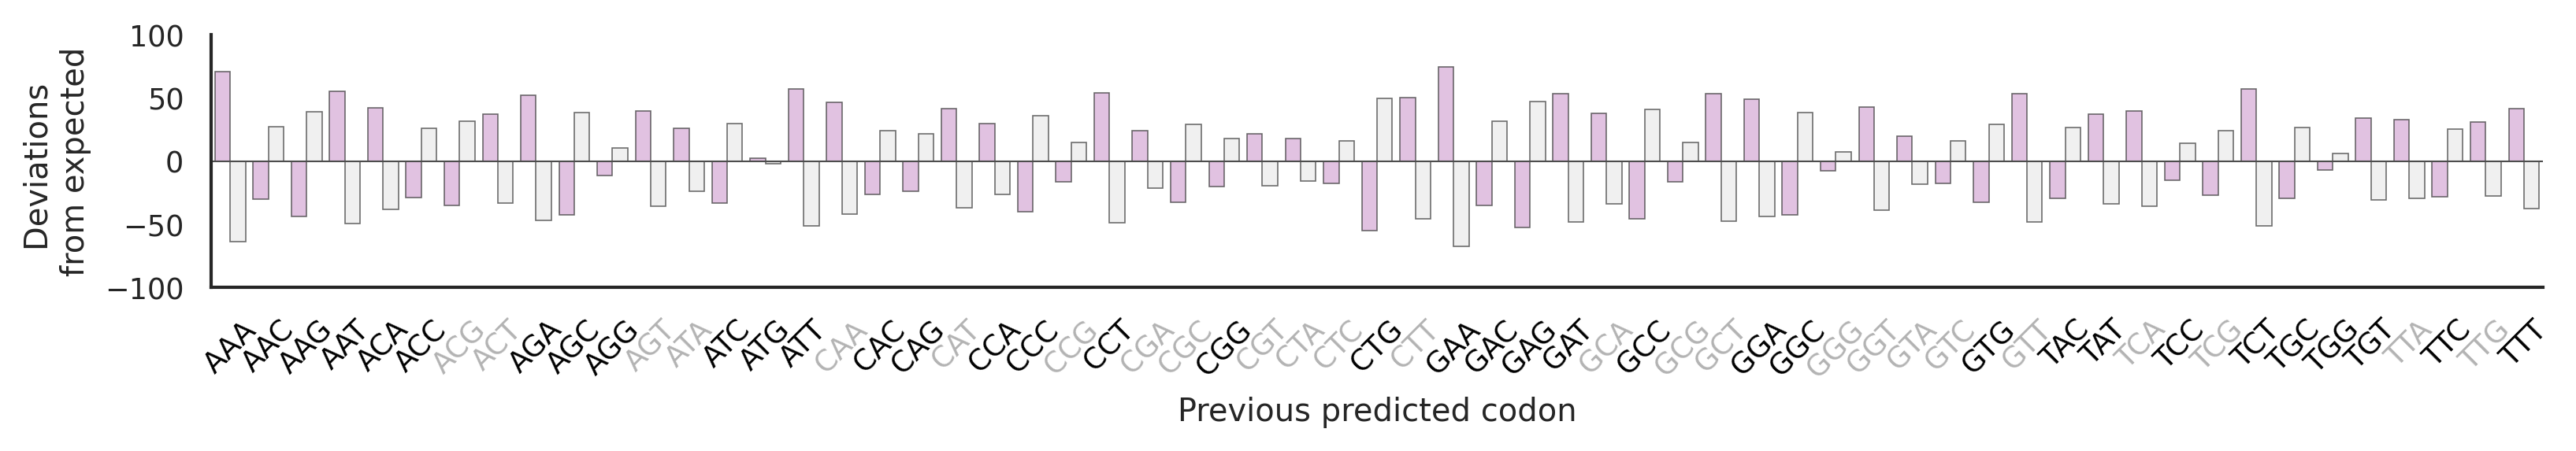

In [39]:
plt.figure(figsize=(11., 2), dpi=300) # Codon label: 3x1.7, AA: 7, Codon: 11x2
ax = sns.barplot(
    data=residuals_rare_long,
    x=label_groupby,
    y="Residual",
    hue="Codon Category",
    palette=["plum", "0.92"], 
    edgecolor="0.2",
    linewidth=0.4,
    alpha=0.7,
    legend=False,
)
# Color x-tick labels gray if codon is rare
for tick_label in ax.get_xticklabels():
    codon = tick_label.get_text()
    if srscu_dict.get(codon, 0) < srscu_threshold_nat:
        tick_label.set_color("0.7")
    else:
        tick_label.set_color("black")

ax.tick_params(axis='x', rotation=45) # 0, 45
ax.set_ylim(-100,100) # 100, 30
ax.axhline(0, color="0.3", linestyle="-", linewidth=0.5)
ax.set_ylabel("Deviations \nfrom expected")
ax.set_xlabel("Previous predicted codon") # predicted codon, amino acid
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_S8_A2.pdf", format="pdf")
plt.show()


In [40]:
num_bins = 10
codon_level_analysis_df["Position Bin"] = pd.cut(codon_level_analysis_df["Relative Codon Position"], bins=np.linspace(0, 100, num_bins+1), labels=range(1, num_bins+1))

In [41]:
obs = codon_level_analysis_df.pivot_table(index="Position Bin", columns="Codon Category", values="Count", aggfunc="sum")
obs_position_common = obs.iloc[:,:2]
obs_position_rare = obs.iloc[:,2:4]
_, p_pos_common, _, expected_pos_common = chi2_contingency(obs_position_common)
_, p_pos_rare, _, expected_pos_rare = chi2_contingency(obs_position_rare)
residuals_pos_common = (obs_position_common - expected_pos_common) / np.sqrt(expected_pos_common)
residuals_pos_rare = (obs_position_rare - expected_pos_rare) / np.sqrt(expected_pos_rare)

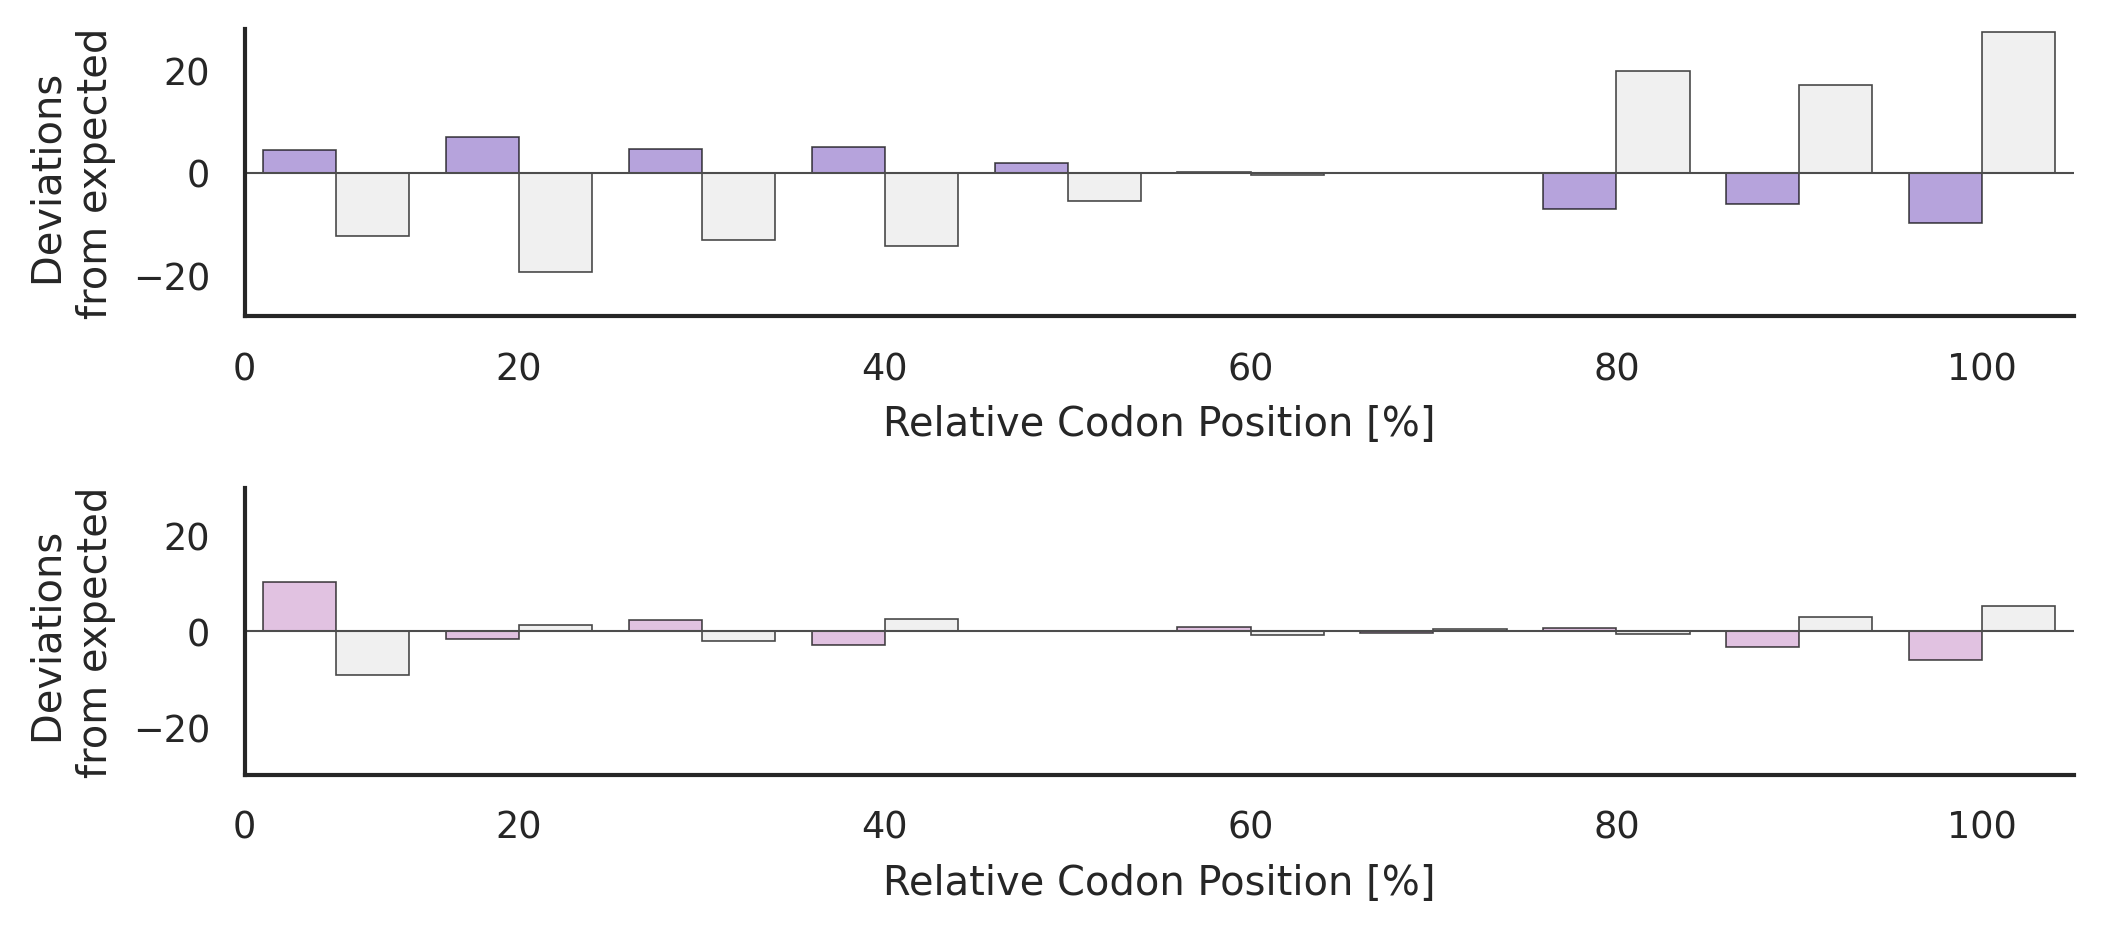

In [42]:
# Melt both DataFrames into long format
rare_long = residuals_pos_rare.reset_index().melt(id_vars="Position Bin", 
    var_name="Codon Category", value_name="Residual")
common_long = residuals_pos_common.reset_index().melt(id_vars="Position Bin", 
    var_name="Codon Category", value_name="Residual")

# Set up plot
fig, axes = plt.subplots(2, 1, figsize=(7.1, 3.2), dpi=300)
# Plot 1: Common codons
sns.barplot(
    data=common_long,
    x="Position Bin", y="Residual", hue="Codon Category",
    palette={
        "Correctly predicted \ncommon codon": "mediumpurple",
        "Misclassified as \nrare codon": "0.92"
    },
    edgecolor="black",
    linewidth=0.4,
    alpha=0.7,
    ax=axes[0],
    legend=False,
)
axes[0].axhline(0, color="0.3", linestyle="-", linewidth=0.5)
axes[0].set_ylabel("Deviations \nfrom expected")
axes[0].set_xlabel("Relative Codon Position [%]")
axes[0].set_ylim(-28, 28)
# Plot 2: Rare codons
sns.barplot(
    data=rare_long,
    x="Position Bin", y="Residual", hue="Codon Category",
    palette={
        "Correctly predicted \nrare codon": "plum",
        "Misclassified as \ncommon codon": "0.92"
    },
    edgecolor="black",
    alpha=0.7,
    linewidth=0.4,
    ax=axes[1],
    legend=False,
)
axes[1].axhline(0, color="0.3", linestyle="-", linewidth=0.5)
axes[1].set_ylabel("Deviations \nfrom expected")
axes[1].set_xlabel("Relative Codon Position [%]")
axes[1].set_ylim(-30, 30)
for ax in axes:
    ax.set_xticks([-0.5, 1, 3, 5, 7, 9])
    ax.set_xticklabels(['0', '20', '40', '60', '80', '100'])
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_3E.pdf", format="pdf")
plt.show()


In [43]:
observed_domain = pd.crosstab(codon_level_analysis_df["Domain"], codon_level_analysis_df["Codon Category"])
observed_domain_commmon = observed_domain.iloc[:,:2]
observed_domain_rare = observed_domain.iloc[:,2:4]
_, p_domain_common, _, expected_domain_common = chi2_contingency(observed_domain_commmon)
_, p_domain_rare, _, expected_domain_rare = chi2_contingency(observed_domain_rare)

residuals_domain_common = (observed_domain_commmon - expected_domain_common) / np.sqrt(expected_domain_common)
residuals_domain_rare = (observed_domain_rare - expected_domain_rare) / np.sqrt(expected_domain_rare)

residuals_domain_rare = residuals_domain_rare.reindex(columns=['Misclassified as \ncommon codon', 'Correctly predicted \nrare codon'])

In [44]:
codon_level_analysis_df["Codon Type"] = codon_level_analysis_df["True sRSCU"].apply(lambda x: "Rare" if x < srscu_threshold_nat else "Common")
codon_level_analysis_df["Domain Label"] = codon_level_analysis_df["Domain"].map({1: "Pfam \ndomain", 0: "Outside \ndomain"})
# Count occurrences
codon_domain_counts = codon_level_analysis_df.groupby(["Domain Label", "Codon Type"]).size().reset_index(name="Count")
# Define order with Pfam first
domain_order = ["Pfam \ndomain", "Outside \ndomain"]

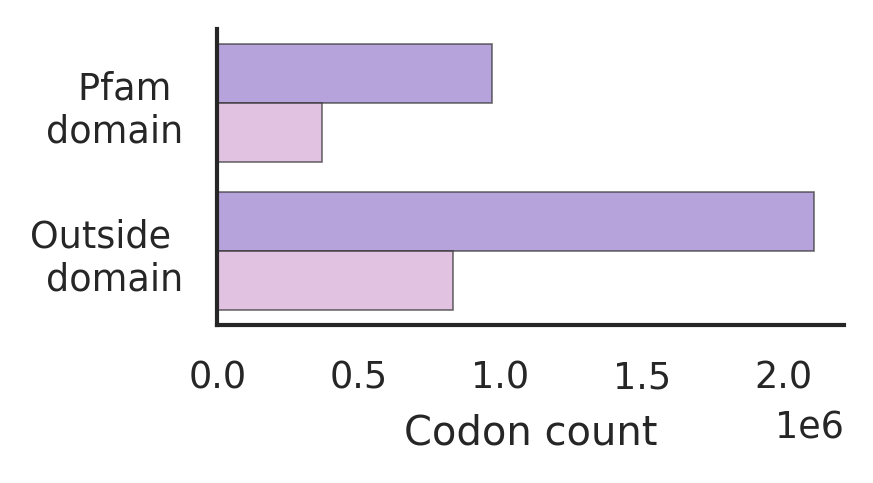

In [45]:
plt.figure(figsize=(3, 1.7), dpi=300)
sns.barplot(
    data=codon_domain_counts,
    y="Domain Label",
    x="Count",
    hue="Codon Type",
    palette={"Common": "mediumpurple", "Rare": "plum"},
    edgecolor=".2",
    alpha=0.7,
    legend=False,
    linewidth=0.4,
    orient='h',
    order=domain_order  # Force Pfam to appear first
)
plt.xlabel("Codon count")
plt.ylabel("")
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_3F_1.pdf", format="pdf")
plt.show()


In [46]:
residuals_domain_long = residuals_domain_common.reset_index().melt(
    id_vars="Domain",
    var_name="Codon Category",
    value_name="Residual"
)

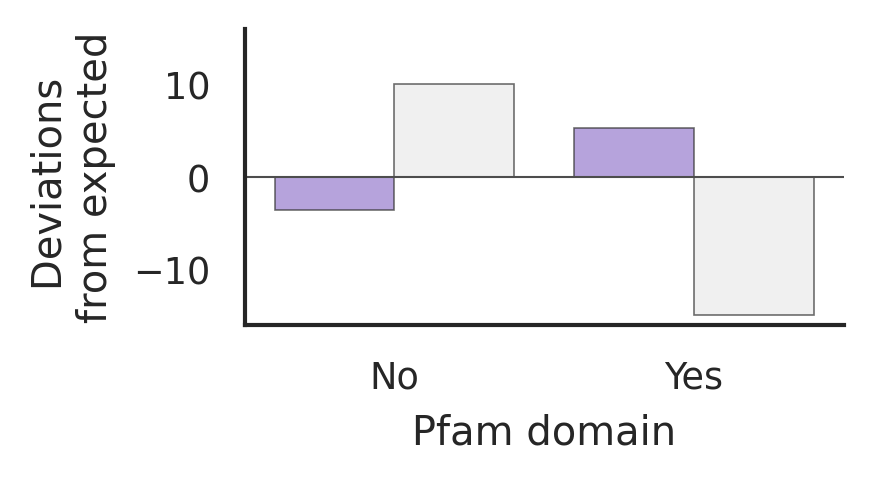

In [47]:
plt.figure(figsize=(3., 1.7), dpi=300)
ax = sns.barplot(
    data=residuals_domain_long,
    x="Domain",
    y="Residual",
    hue="Codon Category",
    palette=["mediumpurple", "0.92"],
    edgecolor="0.2",
    linewidth=0.4,
    alpha=0.7,
    legend=False,
)
ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_ylim(-16,16)
ax.axhline(0, color="0.3", linestyle="-", linewidth=0.5)
ax.set_ylabel("Deviations \nfrom expected")
ax.set_xlabel("Pfam domain")
sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_3F_2.pdf", format="pdf")
plt.show()


# Figure 4 : In silico testing internal consistency of language model

In [52]:
# Convert to amino acid dictionaries using aa_to_codon
rscu_table = {aa: {codon: srscu_dict.get(codon, 0) for codon in codons} for aa, codons in aa_to_codon.items()}

# Select 100 random human protein sequences
human_sequences = (human_testset_df
                  .assign(seq_length=lambda x: x["protein"].str.len())  
                  .query("seq_length <= 500")  # Filter sequences <= 500 amino acids
                  ["protein"].tolist()) 
# Store results in a list for later conversion
data_records = []

# Process each sequence with a progress bar
for seq_idx, protein_seq in tqdm(enumerate(human_sequences, start=1), total=len(human_sequences), desc="Processing sequences"):
    # Generate prompt
    prompt = ">>Homo sapiens<< " + protein_seq
    # Generate codon sequences
    codon_sequences = {
        "highest": get_codon_sequences(protein_seq, rscu_table, strategy="highest"),
        "lowest": get_codon_sequences(protein_seq, rscu_table, strategy="lowest"),
    }

    low_srscu_generated_token_ids, seq_score = constrained_decoding(model, tokenizer, prompt, codon_sequences["lowest"], device=device)
    
    high_srscu_codons = ["</s>"] + [codon_sequences["highest"][j:j+3] for j in range(0, len(codon_sequences["highest"]), 3)] + ["</s>"]
    high_srscu_generated_token_ids = torch.tensor([[tokenizer._convert_token_to_id(c) for c in high_srscu_codons]], device=device)

    # Process each strategy
    for strategy, seq in codon_sequences.items():
        # Get model outputs
        if strategy == "highest":
            probs = extract_probs_from_logits(seq_score, high_srscu_generated_token_ids[0], device=device)
        else:
            probs = extract_probs_from_logits(seq_score, low_srscu_generated_token_ids, device=device)

        # Store per-position data in a structured format
        for pos, aa in enumerate(protein_seq):  # Loop through each codon position
            data_records.append({
                "protein_sequence": seq_idx,  # Store sequence ID (or use full sequence)
                "codon_position": pos,
                "amino_acid": aa,
                "strategy": strategy,
                "probability": probs[pos]
            })

df_results = pd.DataFrame(data_records)

Processing sequences:   0%|                                                                                                   | 0/2372 [00:00<?, ?it/s]

Processing sequences: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2372/2372 [01:48<00:00, 21.76it/s]


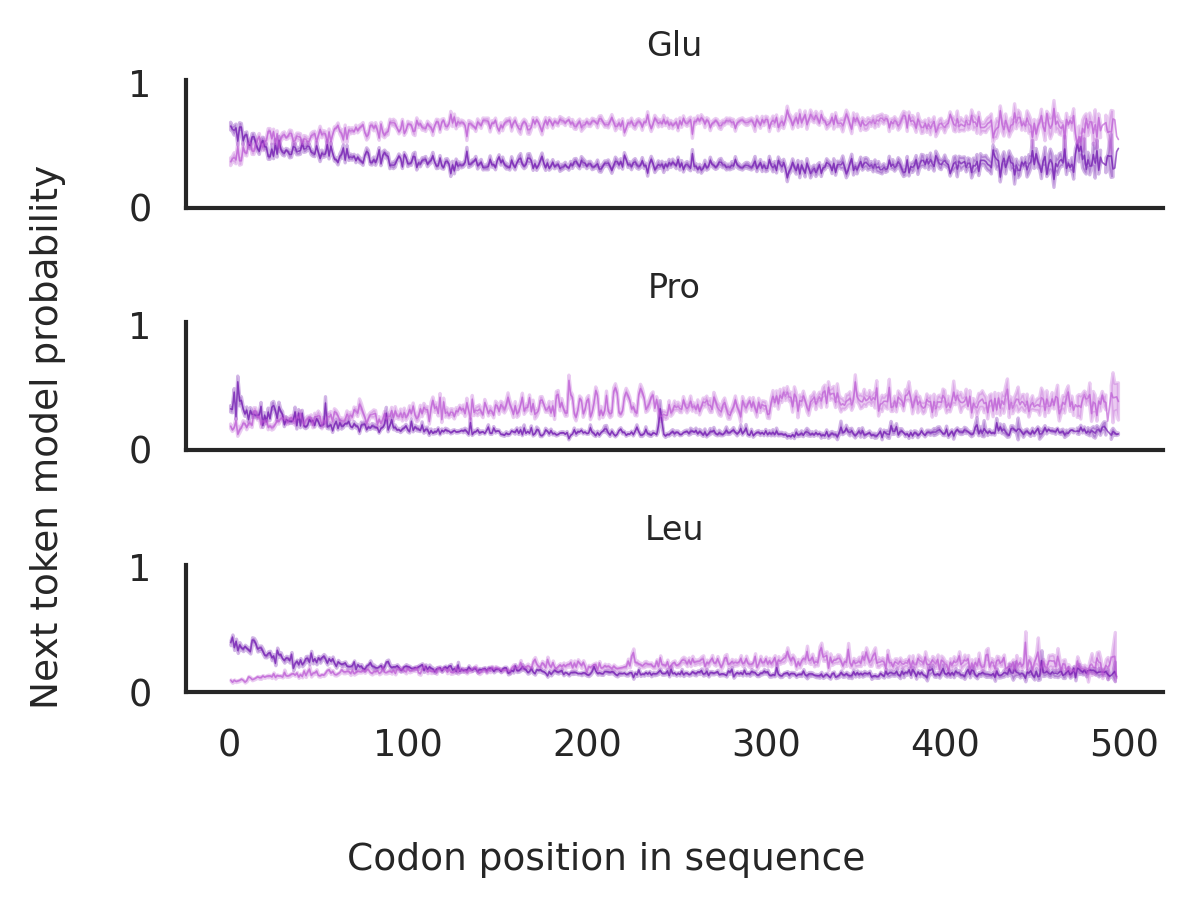

In [55]:
custom_palette = sns.color_palette(["#6a0dad","#ba55d3"])
selected_aas = ['E', 'P', 'L']
fig, axes = plt.subplots(3, 1, figsize=(4, 3), sharex=True, sharey=True, dpi=300)

# Plot each amino acid
for i, aa in enumerate(selected_aas):
    # Filter and group data
    df_aa = df_results[df_results["amino_acid"] == aa]
    grouped = df_aa.groupby(["strategy", "codon_position"])["probability"].agg(
        mean="mean",
        sem="sem"
    ).reset_index()
    
    # Add confidence intervals
    grouped["ci_upper"] = grouped["mean"] + 1.96 * grouped["sem"]
    grouped["ci_lower"] = grouped["mean"] - 1.96 * grouped["sem"]
    
    for strategy, color in zip(["highest", "lowest"], custom_palette):
        subset = grouped[grouped["strategy"] == strategy]
        axes[i].plot(subset["codon_position"], subset["mean"], 
                    color=color, alpha=0.65, linewidth=0.4)
        axes[i].fill_between(subset["codon_position"], 
                           subset["ci_lower"], subset["ci_upper"], 
                           color=color, alpha=0.3)

    axes[i].set_title(f"{one_to_three_letter[aa]}", fontsize=8)
    axes[i].set_ylim(-0.01, 1.01)
    if i < 2:
        axes[i].set_xlabel('')

fig.supxlabel("Codon position in sequence", fontsize=9)
fig.supylabel("Next token model probability", fontsize=9)
plt.tight_layout()
sns.despine()
plt.savefig(FIGURE_DIR+"figure_4B.pdf", format="pdf")
plt.show()

# Figure 5 : Benchmarking against other codon optimization tools

In [56]:
gfp_seqs = gfp_data["Coding sequence"].str.replace('U', 'T').tolist()
gfp_protein_seq = str(Seq(gfp_seqs[0]).translate()) + '*'
gfp_prompt = ">>Homo sapiens<< " + gfp_protein_seq

In [58]:
y_gfp = []
best_seq_gfp, gfp_sequence_scores = greedy_search(model, tokenizer, gfp_prompt, max_length=300, device=device)   

for variant in tqdm(gfp_seqs, desc="Parsing sequences"):
    target_codon_ids = seq_to_ids(variant + 'TGA', tokenizer)
    generated_sequence, sequence_scores = constrained_decoding(model, tokenizer, gfp_prompt, variant, device=device)
    y_gfp.append(neg_log_likelihood(generated_sequence, sequence_scores))

/mnt/lareaulab/faizi/miniconda3/envs/trias/lib/python3.8/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Parsing sequences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.67it/s]


In [59]:
trias_gfp_seq = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(best_seq_gfp, skip_special_tokens=True))
genscript_gfp_seq = "ATGGTGTCCAAGGGCGAAGAACTGTTTACCGGCGTTGTGCCCATCCTGGTGGAACTGGACGGCGACGTGAATGGCCACAAGTTCAGCGTGTCTGGCGAGGGCGAGGGCGACGCCACATACGGCAAGCTGACCCTGAAATTCATCTGCACCACCGGCAAACTGCCAGTGCCATGGCCCACCCTTGTGACCACACTCACCTACGGCGTGCAATGTTTTAGCCGGTACCCCGACCACATGAAACAGCACGACTTCTTCAAGTCCGCCATGCCTGAGGGATATGTGCAGGAGCGGACCATCTTCTTTAAGGATGATGGAAATTACAAGACAAGAGCCGAAGTGAAGTTCGAGGGCGACACACTGGTCAACAGAATCGAGCTGAAGGGCATCGACTTCAAAGAGGACGGCAACATCCTGGGACATAAGCTGGAATACAACTACAACAGCCACAATGTGTACATCATGGCCGATAAGCAGAAGAACGGCATTAAGGTGAACTTCAAGATCAGGCACAACATCGAAGATGGCAGCGTGCAGCTGGCCGACCACTACCAGCAGAACACCCCTATCGGCGATGGACCTGTGCTGCTGCCTGACAACCACTACCTGTCTACACAGTCTGCTCTGAGCAAGGACCCCAACGAGAAGCGGGACCACATGGTCCTGCTGGAATTCGTGACAGCCGCCGGAATCACCCTGGGCATGGATGAGCTGTACAAGAGAAGCAGAGATATCAGCCACGGCTTCCCTCCTGCCGTGGCCGCTCAGGACGACGGCACCCTGCCTATGAGCTGCGCCCAAGAGAGCGGCATGGACAGACACCCTGCTGCCTGCGCCAGCGCCAGAATCAACGTGTGA"
idt_gfp_seq =       "ATGGTTAGTAAAGGGGAAGAATTGTTTACAGGCGTAGTGCCTATATTGGTTGAGCTGGACGGTGATGTAAACGGGCATAAGTTCTCCGTCAGCGGTGAAGGCGAGGGAGATGCCACTTATGGAAAATTGACATTGAAATTTATCTGCACAACAGGGAAGCTGCCCGTGCCGTGGCCCACTTTGGTTACAACACTCACATACGGCGTGCAATGTTTCTCTCGGTATCCCGACCACATGAAACAGCATGACTTTTTCAAAAGTGCGATGCCTGAAGGATACGTGCAAGAACGGACCATCTTCTTTAAAGACGACGGTAATTATAAGACAAGAGCAGAAGTTAAGTTCGAAGGAGATACACTTGTCAACAGGATAGAGCTGAAGGGGATTGATTTTAAGGAGGACGGCAATATATTGGGTCACAAACTCGAGTATAATTATAATTCACATAACGTCTATATAATGGCGGACAAGCAGAAGAATGGGATTAAAGTTAATTTCAAGATCAGACATAATATAGAAGATGGAAGTGTACAACTGGCCGACCATTATCAGCAGAATACTCCGATTGGGGACGGACCCGTCCTTCTGCCAGATAACCACTATCTCTCAACCCAGTCAGCTCTTAGCAAGGATCCAAACGAGAAGCGAGATCACATGGTACTTTTGGAATTTGTCACTGCAGCTGGCATCACCCTGGGGATGGACGAACTTTATAAGCGCAGCCGCGATATTAGCCATGGATTTCCCCCGGCTGTCGCAGCCCAGGATGATGGCACGCTTCCCATGTCATGTGCGCAGGAGAGCGGTATGGATAGACACCCAGCGGCCTGTGCCTCCGCGAGGATTAACGTCTAG"
twist_gfp_seq =     "ATGGTGTCTAAAGGAGAGGAGCTGTTCACTGGAGTAGTGCCCATATTGGTGGAGCTTGATGGGGACGTCAATGGCCATAAGTTCAGCGTGTCTGGCGAGGGCGAGGGAGATGCAACTTACGGAAAACTCACATTGAAATTCATCTGCACTACCGGAAAGCTTCCAGTGCCGTGGCCCACGCTGGTGACGACCCTCACTTACGGTGTTCAGTGTTTTTCCCGGTATCCAGACCACATGAAGCAGCACGACTTTTTCAAAAGTGCAATGCCAGAAGGTTACGTTCAAGAAAGGACCATCTTTTTTAAAGATGACGGGAATTACAAGACCCGGGCCGAAGTCAAGTTCGAAGGCGATACACTTGTGAATAGAATCGAGCTGAAAGGGATCGACTTTAAGGAGGACGGCAACATCCTGGGACATAAGCTGGAATATAATTATAACTCTCATAATGTCTATATTATGGCCGACAAGCAGAAGAATGGTATTAAGGTGAATTTTAAGATCCGACACAACATAGAGGATGGTAGCGTCCAATTGGCGGATCATTACCAGCAGAACACACCCATTGGCGACGGGCCGGTGCTCCTGCCAGATAACCACTATCTGTCAACCCAGTCCGCCCTCAGCAAAGACCCCAACGAGAAACGCGACCACATGGTACTGCTGGAATTCGTGACAGCTGCAGGCATCACACTCGGGATGGATGAGCTGTACAAACGATCCAGGGACATTTCCCATGGGTTCCCTCCTGCCGTTGCTGCTCAAGATGACGGCACCCTCCCTATGTCATGTGCGCAGGAAAGTGGCATGGATAGACACCCTGCAGCCTGCGCTAGCGCCCGCATTAACGTCTAG"

In [60]:
variant = twist_gfp_seq
target_codon_ids = seq_to_ids(variant, tokenizer)
generated_sequence, sequence_scores = constrained_decoding(model, tokenizer, gfp_prompt, variant, device=device)
neg_log_likelihood(generated_sequence, sequence_scores)

1.131462440020326

In [61]:
scores = {
    'Trias': 0.21,
    'GenScript': 0.86,
    'IDT': 1.22,
    'Twist': 1.13
}

1.375428564479097e-06
6.7816871495236485e-09
2.0961701437308364e-08


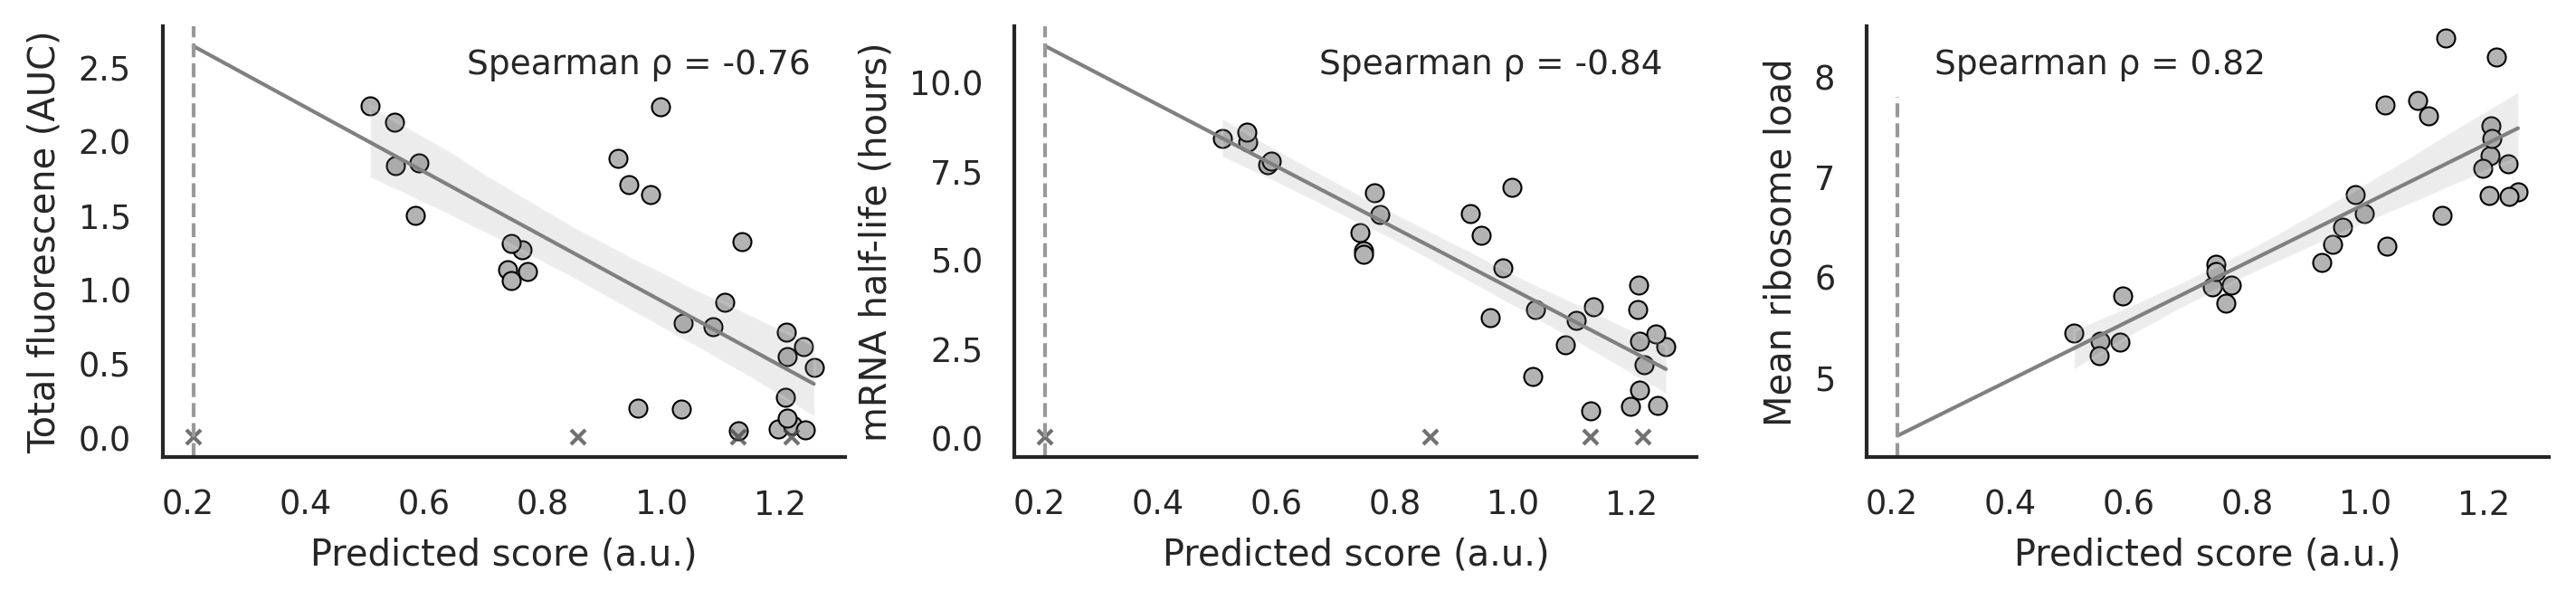

In [62]:
metrics = ["AUC expression (HEK293)", "half-life (HEK293)", "Mean ribosome load (HEK293)"]
labels = ["Total fluorescene (AUC)", "mRNA half-life (hours)", "Mean ribosome load"]
positions = [(0.95, 0.95), (0.95, 0.95), (0.10, 0.95)]
color_palette = [str(x) for x in np.linspace(0.8, 0.2, 6)]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(9.6, 2.3), dpi=300)
axes = axes.flatten() 
# Create scatter plots for each metric
for i, metric in enumerate(metrics):
    sns.scatterplot(x=y_gfp, y=gfp_data[metric], color='0.7', ax=axes[i],  edgecolor='black', linewidth=0.5)
    axes[i].plot(list(scores.values()), [0] * len(scores), 'x', color='0.3', markersize=4, markeredgewidth=1, alpha=0.8) 
    # Add regression line
    sns.regplot(x=y_gfp, y=gfp_data[metric], ax=axes[i], scatter=False, color='0.5', line_kws={"linewidth":1})
    # Calculate and display R²
    slope, intercept, r_value, p_value, std_err = linregress(y_gfp, gfp_data[metric])
    # Calculate Spearman rho
    rho, pval = spearmanr(y_gfp, gfp_data[metric])
    print(pval)
    # Determine where to place the R^2 annotation
    text_x, text_y = positions[i]
    h_align = 'right' if text_x == 0.95 else 'left'
    # Display Spearman ρ
    axes[i].text(text_x, text_y, f'Spearman ρ = {rho:.2f}', transform=axes[i].transAxes, fontsize=9, horizontalalignment=h_align, verticalalignment='top')
    # Extrapolate the regression line
    x_min, x_max = min(y_gfp), max(y_gfp)
    x_values = np.linspace(x_min, scores['Trias'], 100) 
    y_values = slope * x_values + intercept
    axes[i].plot(x_values, y_values, color='0.5', linestyle='-', linewidth=1)
    if i ==2:
        axes[i].vlines(x=scores['Trias'], ymin=4.2, ymax=7.8, color='0.6', linestyle='--', linewidth=1)
        axes[i].set_ylim(4.2,8.5)
    else:
        axes[i].axvline(x=scores['Trias'], color='0.6', linestyle='--', linewidth=1)

    axes[i].set_xlabel('Predicted score (a.u.)')
    axes[i].set_ylabel(labels[i])
    # Use scientific notation for the y-axis on the first subplot
    if i == 0:
        axes[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    sns.despine(ax=axes[i], top=True, right=True)


plt.tight_layout()
plt.savefig(FIGURE_DIR+'figure_5A.pdf', format="pdf")
plt.show()


In [72]:
# Define window size
window_size = 18

sorted_idx = np.argsort(gfp_data["AUC expression (HEK293)"].values)[::-1]
gfp_seqs = [gfp_seqs[i] for i in sorted_idx]

# Extract all GFP codon sequences
gfp_codon_seqs = {f"GFP Variant {i+1}": [gfp_seqs[idx][j:j+3] for j in range(0, len(gfp_seqs[idx]), 3)] + ['TGA']
                   for i, idx in enumerate(range(len(gfp_seqs)))}

# Compute min/max profiles for all GFP sequences
gfp_min_max_profiles = {name: calculate_min_max(seq, abs_codon_count_dict, codon_to_aa, window_size)
                        for name, seq in gfp_codon_seqs.items()}

# Compute min/max profiles for synthetic sequences
synthetic_sequences = {
    "Trias": [trias_gfp_seq[i:i+3] for i in range(0, len(trias_gfp_seq), 3)],
    "GenScript": [genscript_gfp_seq[i:i+3] for i in range(0, len(genscript_gfp_seq), 3)],
    "Twist": [twist_gfp_seq[i:i+3] for i in range(0, len(twist_gfp_seq), 3)],
    "IDT": [idt_gfp_seq[i:i+3] for i in range(0, len(idt_gfp_seq), 3)],
}

synthetic_min_max_profiles = {name: calculate_min_max(seq, abs_codon_count_dict, codon_to_aa, window_size)
                              for name, seq in synthetic_sequences.items()}

dtw_df = compute_dtw_matrix(synthetic_min_max_profiles, gfp_min_max_profiles)

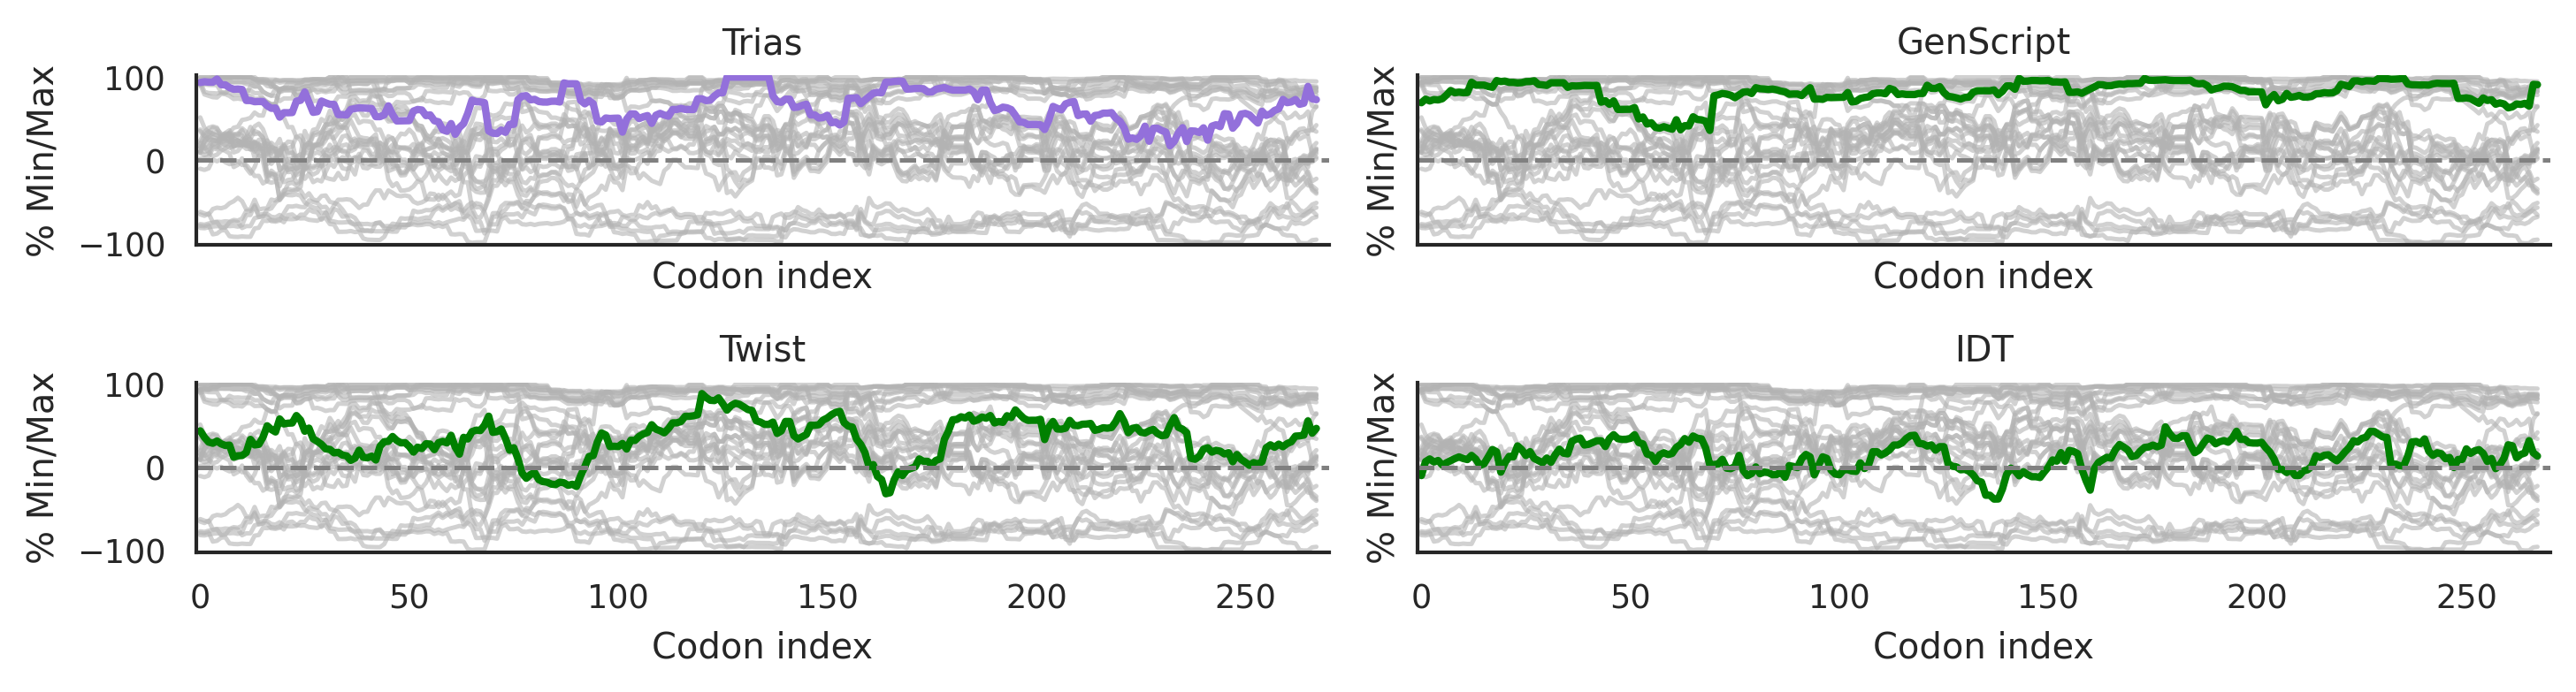

In [73]:
# Define colors for different categories
gfp_colors = sns.color_palette("Greys", n_colors=len(gfp_min_max_profiles))
color_palette = [str(x) for x in np.linspace(0.8, 0.2, 6)]
colors = [color_palette[j // 5] for j in range(len(y_gfp))]
synthetic_order = ["Trias", "GenScript", "Twist", "IDT"]

fig, axes = plt.subplots(2, 2, figsize=(9.8, 2.7), sharex=True, sharey=True, dpi=300)
for ax, synthetic_name in zip(axes.flat, synthetic_order):
    codon_indices = list(range(len(next(iter(gfp_min_max_profiles.values())))))
    # Plot selected GFP sequences (subset if necessary)
    for i, (name, profile) in enumerate(list(gfp_min_max_profiles.items())):
        ax.plot(codon_indices, profile, color='0.7', alpha=0.6, label=name) #
    # Plot the specific synthetic sequence in its designated panel
    color = 'mediumpurple' if synthetic_name == "Trias" else 'green'
    ax.plot(codon_indices, synthetic_min_max_profiles[synthetic_name], color=color, alpha=1, linewidth=2, label=synthetic_name)

    ax.axhline(0, color='0.5', linestyle='--')
    ax.set_title(synthetic_name)
    ax.set_xlim(-1, 270)
    ax.set_ylim(-102, 102)
    ax.set_xlabel("Codon index")
    ax.set_ylabel("% Min/Max")
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_5B.pdf", format="pdf")
plt.show()

In [74]:
gfp_df = gfp_data[['Unnamed: 0', 'sequence class', 'Coding sequence']+metrics].copy()
gfp_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
gfp_df['trias_score'] = y_gfp
gfp_df['Coding sequence'] = gfp_df['Coding sequence'].str.replace('U', 'T') + 'TGA'
sources = ['trias', 'idt', 'twist', 'genscript']
ref_seqs = {source: globals()[f'{source}_gfp_seq'] for source in sources}

In [75]:
# Codon similarities and euclidean distance scores 
for source in sources:
    gfp_df[f'codon_similarity_{source}'] = gfp_df['Coding sequence'].apply(
        lambda seq: sequence_similarity(ref_seqs[source], seq, sequence_type='codon')
    )
    ref_codons = seq_to_codons(ref_seqs[source])
    ref_min_max = calculate_min_max(ref_codons, abs_codon_count_dict, codon_to_aa, 18)
    gfp_df[f'euclidean_{source}'] = gfp_df['Coding sequence'].apply(
        lambda seq: euclidean(calculate_min_max(seq_to_codons(seq), abs_codon_count_dict, codon_to_aa, 18), ref_min_max)/(len(seq)/3)
    )

In [76]:
# Get indices of 3 highest and 3 lowest expression sequences
highest_expr_idx = gfp_df.nlargest(5, 'AUC expression (HEK293)').index
lowest_expr_idx = gfp_df.nsmallest(5, 'AUC expression (HEK293)').index

# Calculate averages for each metric and company
sources = ['trias', 'genscript', 'twist', 'idt']
averages = {
    'codon_similarity': {
        'high': [],
        'low': []
    },
    'euclidean': {
        'high': [],
        'low': []
    }
}

# Calculate averages
for source in sources:
    # Codon similarity averages
    averages['codon_similarity']['high'].append(
        gfp_df.loc[highest_expr_idx, f'codon_similarity_{source}'].mean()
    )
    averages['codon_similarity']['low'].append(
        gfp_df.loc[lowest_expr_idx, f'codon_similarity_{source}'].mean()
    )
    
    # DTW averages
    averages['euclidean']['high'].append(
        gfp_df.loc[highest_expr_idx, f'euclidean_{source}'].mean()
    )
    averages['euclidean']['low'].append(
        gfp_df.loc[lowest_expr_idx, f'euclidean_{source}'].mean()
    )
    

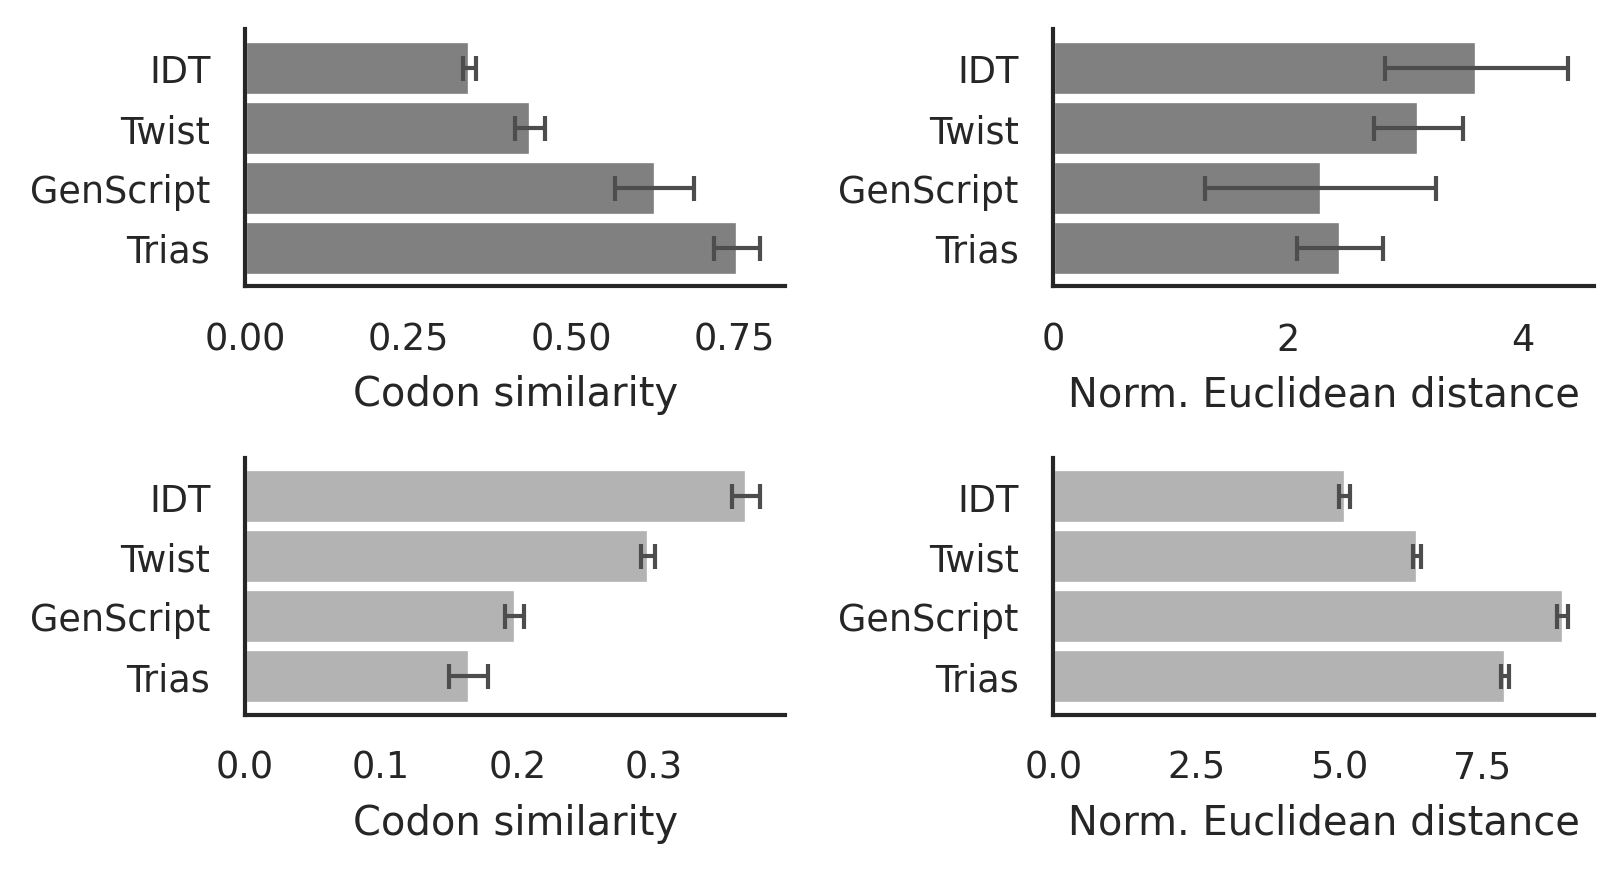

In [77]:
# Setup
fig, axes = plt.subplots(2, 2, figsize=(5.5, 3), dpi=300)
height = 0.9
labels = ['Trias', 'GenScript', 'Twist', 'IDT']  # Reverse order for display
y = np.arange(len(sources))  # Reverse y positions

# Calculate standard errors
se_dict = {
    'codon_high': [gfp_df.loc[highest_expr_idx, f'codon_similarity_{s}'].std() / np.sqrt(3) for s in sources],
    'codon_low': [gfp_df.loc[lowest_expr_idx, f'codon_similarity_{s}'].std() / np.sqrt(3) for s in sources],
    'euclidean_high': [gfp_df.loc[highest_expr_idx, f'euclidean_{s}'].std() / np.sqrt(3) for s in sources],
    'euclidean_low': [gfp_df.loc[lowest_expr_idx, f'euclidean_{s}'].std() / np.sqrt(3) for s in sources]
}

# Plot configurations
plot_configs = [
    {'data': averages['codon_similarity']['high'], 'err': se_dict['codon_high'], 'xlabel': 'Codon similarity'},
    {'data': averages['euclidean']['high'], 'err': se_dict['euclidean_high'], 'xlabel': 'Norm. Euclidean distance'},
    {'data': averages['codon_similarity']['low'], 'err': se_dict['codon_low'], 'xlabel': 'Codon similarity'},
    {'data': averages['euclidean']['low'], 'err': se_dict['euclidean_low'], 'xlabel': 'Norm. Euclidean distance'}
]

# Create plots
for ax, config in zip(axes.flat, plot_configs):
    ax.barh(y, config['data'], height,
            xerr=config['err'],
            error_kw={'ecolor': '0.3', 'capsize': 3, 'capthick': 1, 'elinewidth': 1},
            color='0.5' if ax in axes[0] else '0.7')
    ax.set_xlabel(config['xlabel'])
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_5C.pdf", format="pdf")
plt.show()

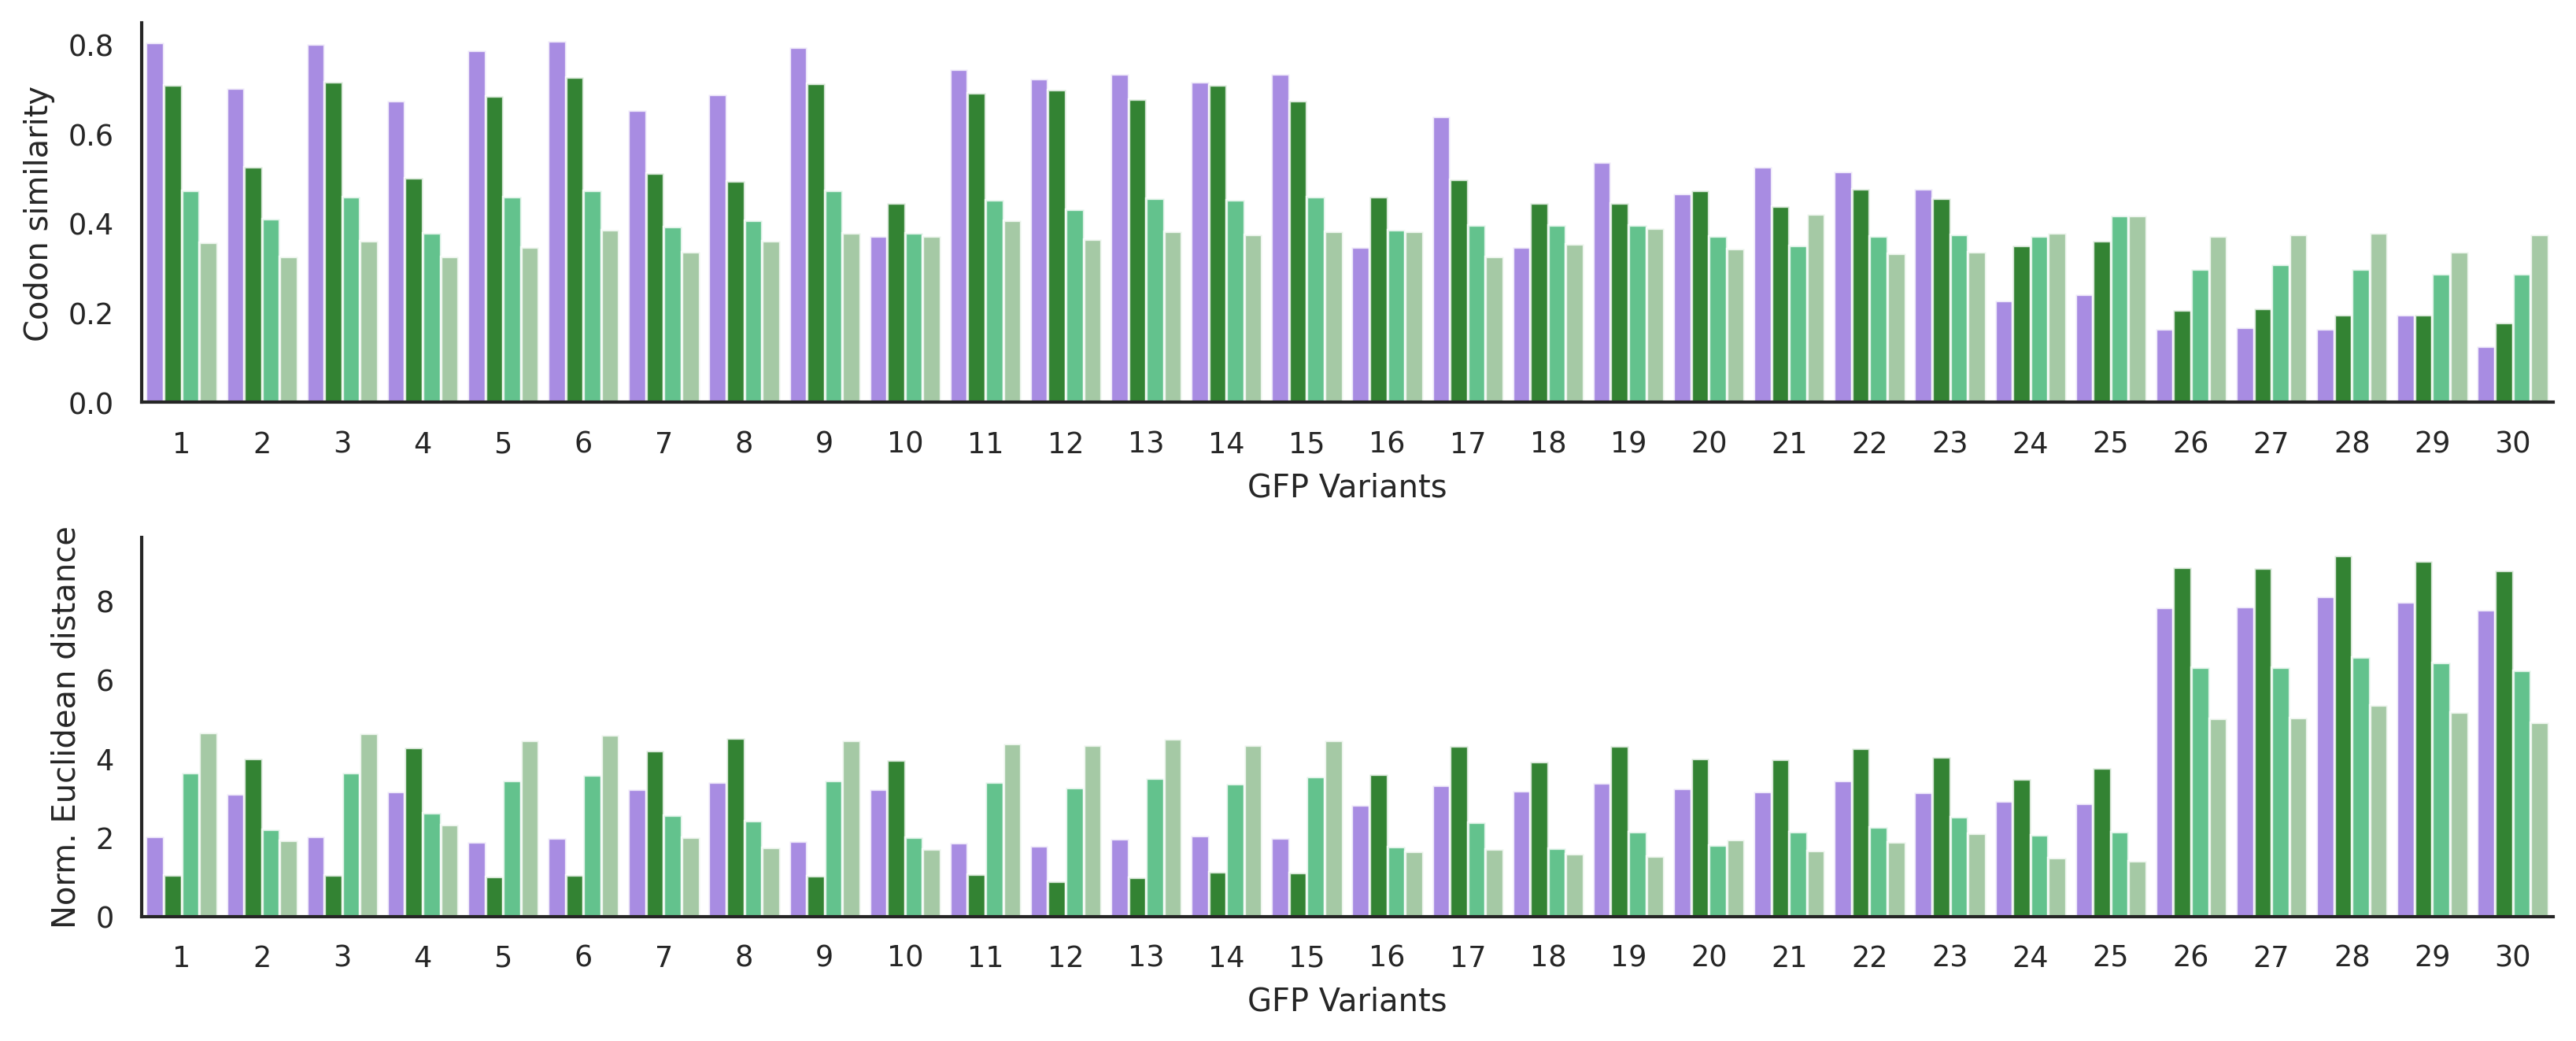

In [78]:
# Sort and label variants
sorted_df = gfp_df.sort_values('AUC expression (HEK293)', ascending=False)
variant_numbers = range(1, len(sorted_df) + 1)
x = np.arange(len(sorted_df))
width = 0.221
# Colors and offsets
colors = ['mediumpurple', 'darkgreen', 'mediumseagreen', 'darkseagreen']
source_offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

# Plot settings
metrics = ['codon_similarity', 'euclidean']
ylabels = ['Codon similarity', 'Norm. Euclidean distance']

fig, axes = plt.subplots(2, 1, figsize=(11, 4.5), dpi=300)
for ax, metric, ylabel in zip(axes, metrics, ylabels):
    all_values = []

    for idx, source in enumerate(sources):
        values = sorted_df[f'{metric}_{source}']
        all_values.append(values)

        ax.bar(x + source_offsets[idx], values, width,
               label=source.capitalize(),
               color=colors[idx], alpha=0.8)
        
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(variant_numbers)
    ax.set_xlabel('GFP Variants')
    ax.set_xlim(-0.5, 29.5) 

sns.despine()
plt.tight_layout()
plt.savefig(FIGURE_DIR+"figure_S11_A_B.pdf", format="pdf")
plt.show()
